**If you think this notebook deserves an upvote, I'd love to have it. An upvote per view, its all I ask**
(credit to [Dan Carlin](https://twitter.com/HardcoreHistory) for coining the phrase ;-) 

---------------------------------------

This is part of a series of notebooks about practical time series methods:

* [Part 0: the basics](https://www.kaggle.com/konradb/ts-0-the-basics)
* [Part 1a: smoothing methods](https://www.kaggle.com/konradb/ts-1a-smoothing-methods)
* [Part 1b: Prophet](https://www.kaggle.com/konradb/ts-1b-prophet) 
* [Part 2: ARMA](https://www.kaggle.com/konradb/ts-2-arma-and-friends)
* [Part 3: Time series for finance](https://www.kaggle.com/konradb/ts-3-time-series-for-finance) 
* [Part 4: Sales and demand forecasting](https://www.kaggle.com/konradb/ts-4-sales-and-demand-forecasting)
* [Part 5: Automatic for the people](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people) 
* [Part 6: Deep learning for TS - sequences](https://www.kaggle.com/konradb/ts-6-deep-learning-for-ts-sequences)
* [Part 7: Survival analysis](https://www.kaggle.com/konradb/ts-7-survival-analysis)
* [Part 8: Hierarchical time series](https://www.kaggle.com/konradb/ts-8-hierarchical-time-series) 
* [Part 9: Hybrid methods](https://www.kaggle.com/code/konradb/ts-9-hybrid-methods/)
* [Part 10: Validation methods for time series](https://www.kaggle.com/code/konradb/ts-10-validation-methods-for-time-series/)
* [Part 11: Deep learning for TS - transfer learning](https://www.kaggle.com/konradb/ts-10-deep-learning-for-ts-transfer-learning/) - **this notebook**



The series is accompanied by video presentations on the YouTube channel of [Abhishek](https://www.kaggle.com/abhishek):

* [Talk 0](https://www.youtube.com/watch?v=cKzXOOtOXYY) 
* [Talk 1](https://www.youtube.com/watch?v=kAI67Sz92-s) - combining the content from parts 1a and 1b
* [Talk 2](https://www.youtube.com/watch?v=LjV5DE3KR-U) 
* [Talk 3](https://www.youtube.com/watch?v=74rDhJexmTg)
* [Talk 4](https://www.youtube.com/watch?v=RdH8zd07u2E) 
* [Talk 5](https://www.youtube.com/watch?v=wBP8Pc4Wxzs) 
* [Talk 6](https://www.youtube.com/watch?v=81AEI0tj0Kk) 
* [Talk 7](https://www.youtube.com/watch?v=m-8I_hkmz9o)
* [Talk 8](https://www.youtube.com/watch?v=7ZTarg4QYR4)
* [Talk 9](https://www.youtube.com/watch?v=NYZzBvKcfp4)
* [Talk 10](https://www.youtube.com/watch?v=47WeBiLV2Uo) 
* [Talk 11]() - **based on this notebook**


---------------------------------------


Transfer learning is a research problem in ML that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. 
ImageNet was first published in 2009 and over the next few years would go on to form the bedrock of most computer vision models. To this day whether you are training a model to detect pneumonia or classify cars, you will probably start with a model pre-trained on ImageNet or some other large (and general image) dataset. More recently, papers like ELMO and BERT (2018) leveraged transfer learning to effectively improve performance on several NLP tasks. These representations can then be leveraged for a variety of tasks such as question answering, named entity recognition, and much more. Overall, transfer learning has helped progress in areas with limited data availability in both CV and NLP domains. Several modern applications of machine learning are built around TL: need to classify images? Take a large pretrained model, slap an extra head, and off to the races. NLP? You're pretty much limited by your hardware: what's the biggest BERT you can squeeze in.

It's only natural that people would start thinking about using this approach to time series: while less obvious to formulate (what does it mean to learn time series features across domains), the idea of transfer learning for time series has huge potential. In this notebook we explore the idea in some more detail:




* [Groundwork](#section-groundwork)
* [Joint model](#section-joint)
* [TL: pretraining a time series model](#section-tl1)
* [TL: the tinkering](#section-tl2)



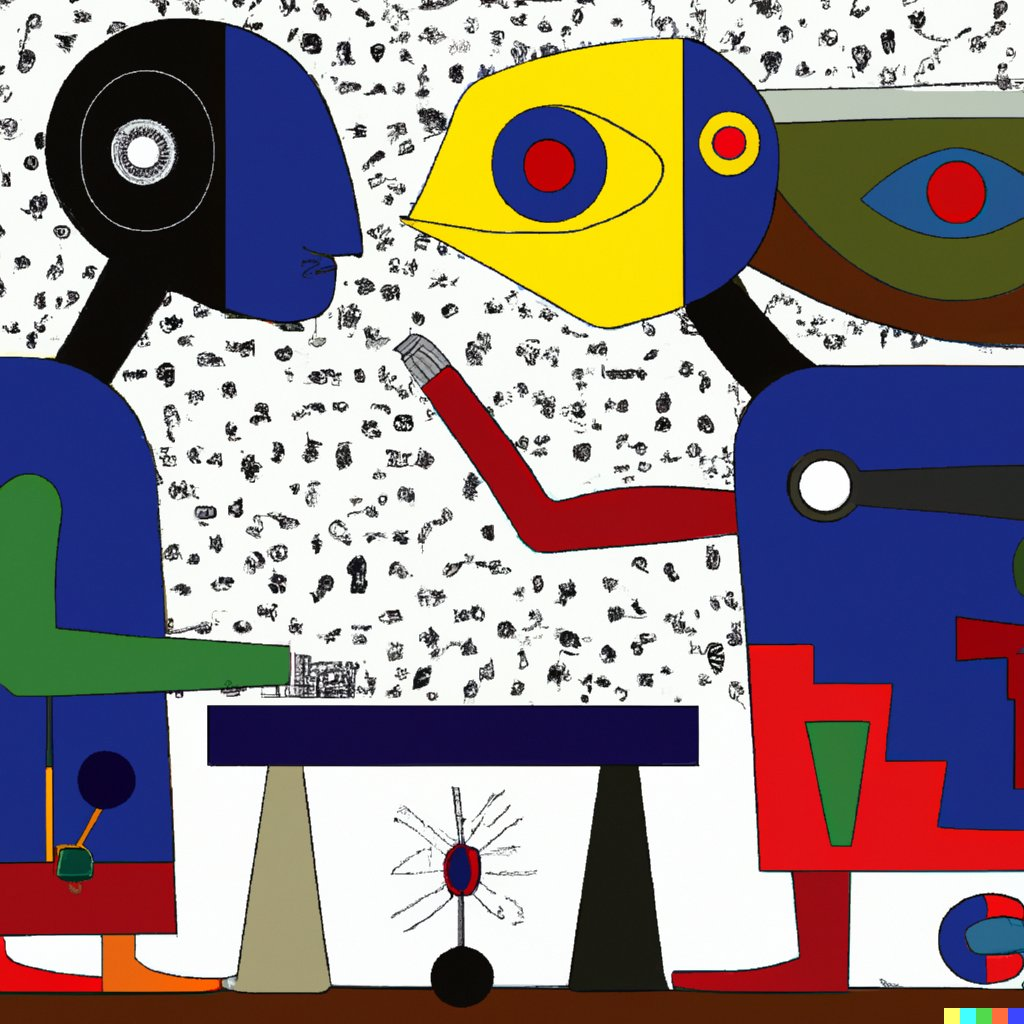

In [1]:
!pip install darts[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.9/451.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.0 MB/s eta 0:00:00
  Attempting uninstall: prophet
    Found existing installation: prophet 1.1
    Uninstalling prophet-1.1:
      Successfully uninstalled prophet-1.1


In [2]:
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
from darts.models import NaiveSeasonal, ARIMA, ExponentialSmoothing, NBEATSModel
from darts.metrics import smape, mase, mape, rmse

import tqdm.notebook as tq

import seaborn as sns

import os
import time
import random
import pandas as pd
import numpy as np

import torch
from torch import nn


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

from typing import List, Tuple, Dict

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [3]:
class CFG:
    seed = 42    
    img_dim1 = 20
    img_dim2 = 10
    horizon = 12
    min_size = 48
    start_point = '2014-01-01'
    which_art = 'FOODS_3_819'
    cutoff_point = '2016-05-08'
    lookback = 120
    lookahead = 14
    nepochs = 10
    bsize = 64
    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   

In [4]:
# function definitions
def plot_series(df, xname):
    xd = df.loc[df.airlineid == xname ]
    airname = xd['Description'].iat[0]
    xd[['data_dte', 'Total']].set_index('data_dte').plot(title = airname, xlabel = '')
    


<a id="section-groundwork"></a>
# Groundwork


Our reference series will be the data from the U.S. International Air Passenger and Freight Statistics Report on air traffic to and from the US: https://www.kaggle.com/datasets/parulpandey/us-international-air-traffic-data

In [5]:
xdat = pd.read_csv('../input/us-international-air-traffic-data/International_Report_Passengers.csv',
                 usecols = ['data_dte', 'airlineid', 'Total']
                  )
xdat['data_dte'] = pd.to_datetime(xdat['data_dte'])
xdat.head(5)

,data_dte,airlineid,Total
0,2014-05-01,19534,315
1,2007-06-01,20364,683
2,2005-12-01,20344,1010
3,2003-04-01,20204,508
4,2005-12-01,20312,76


In [6]:
# we will aggregate to total passenger count per day
xmat = xdat.groupby(['data_dte', 'airlineid'])['Total'].sum().reset_index()
xmat['data_dte'] = pd.to_datetime(xmat['data_dte'])
xmat.sort_values(by = 'data_dte', inplace = True)


# map the identifiers to proper names
xdict = pd.read_csv('../input/airline-codes-mapping/L_AIRLINE_ID.csv')
xmat = pd.merge(left = xmat, right = xdict, left_on = 'airlineid', right_on = 'Code')
xmat.drop('Code', axis = 1, inplace = True)
xmat.head(5)

,data_dte,airlineid,Total,Description
0,1990-01-01,19386,392577,Northwest Airlines Inc.: NW
1,1990-02-01,19386,340101,Northwest Airlines Inc.: NW
2,1990-03-01,19386,400657,Northwest Airlines Inc.: NW
3,1990-04-01,19386,383179,Northwest Airlines Inc.: NW
4,1990-05-01,19386,436067,Northwest Airlines Inc.: NW


In [7]:
# list of names 
names_list = xmat.airlineid.unique()

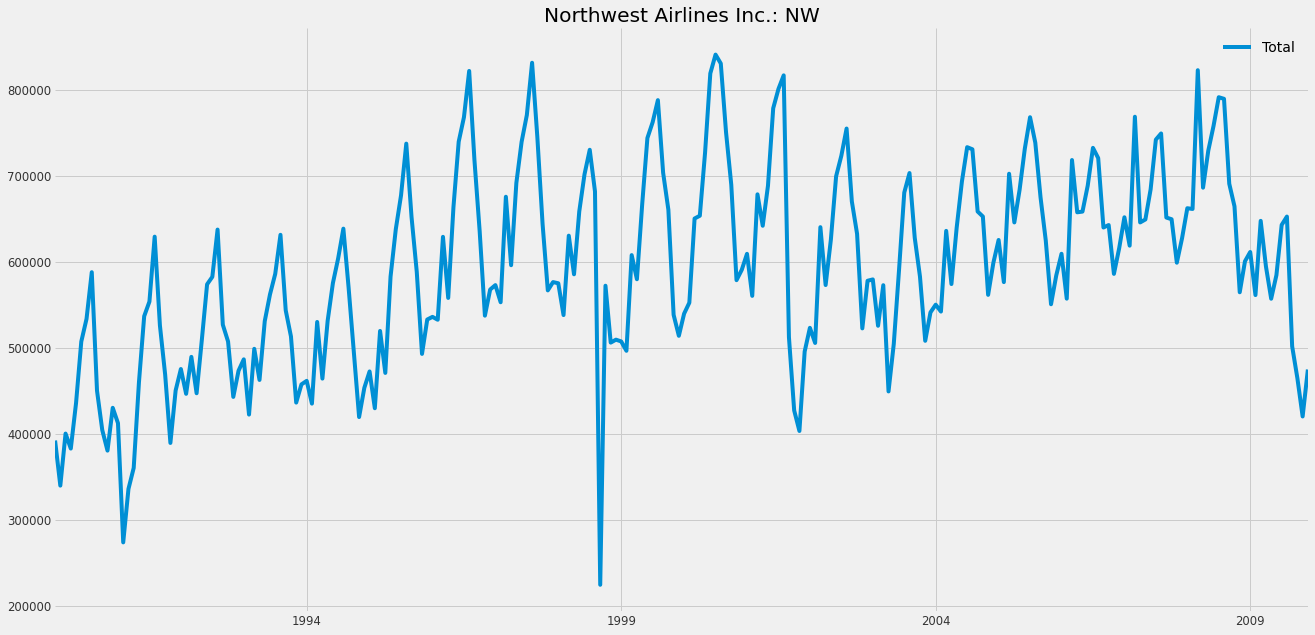

In [8]:
plot_series(xmat, names_list[0])

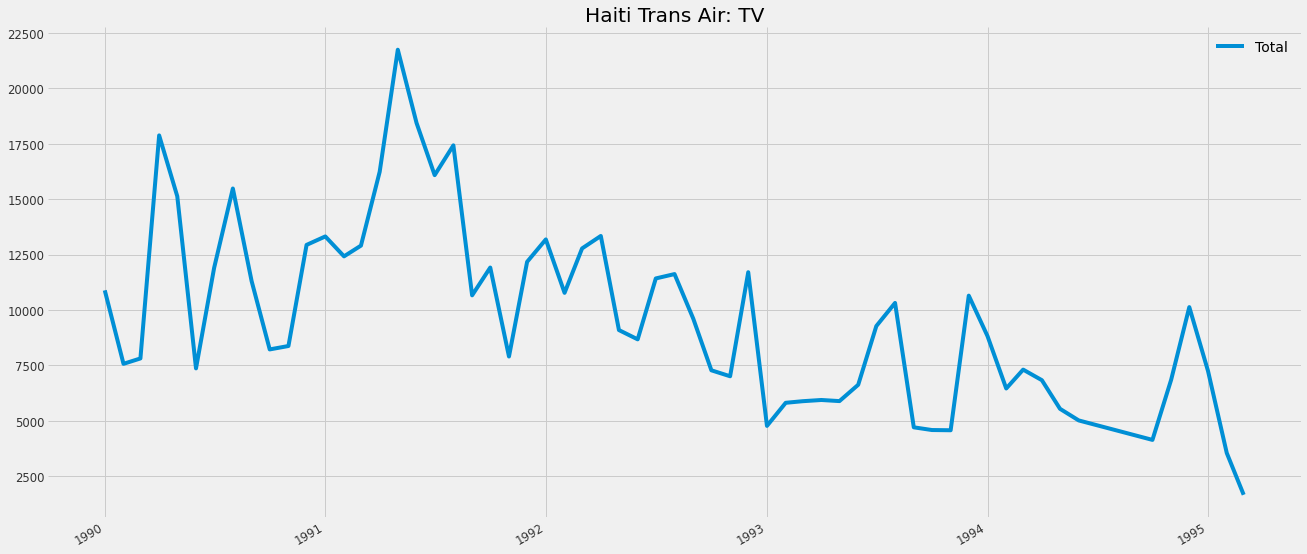

In [9]:
plot_series(xmat, names_list[1])

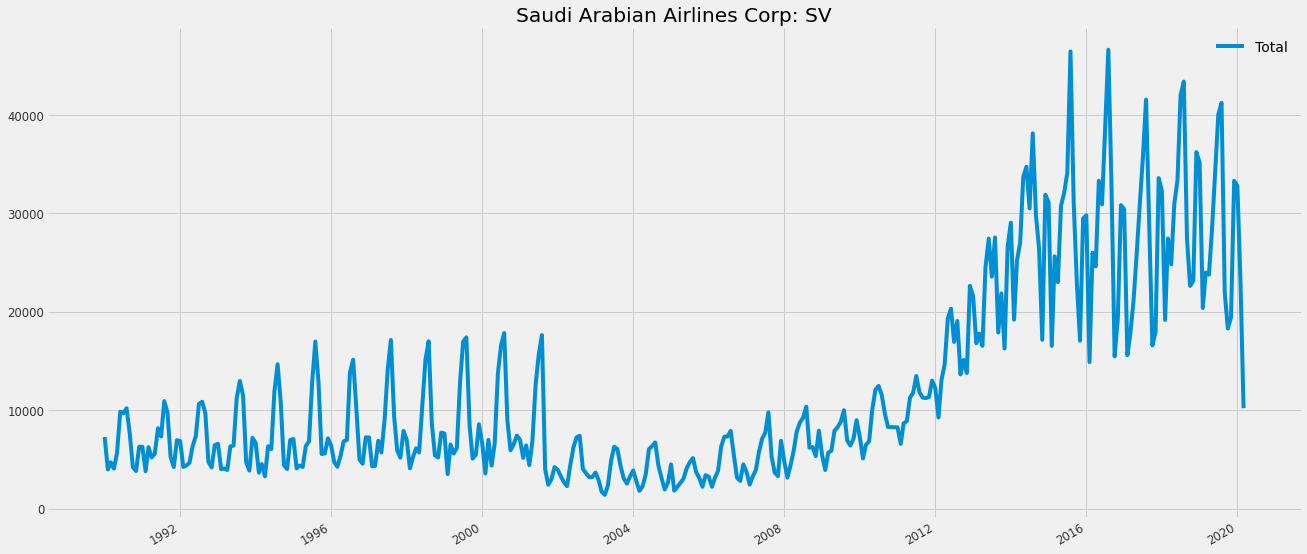

In [10]:
plot_series(xmat, names_list[31])

We can clearly see that the series exhibit quite different dynamics (including number of observations). Let's prepare the our time series with a clean train / test split (for a refresher about *proper* way to do cross-validation for time series, please check out [Episode 10](https://www.kaggle.com/code/konradb/ts-10-validation-methods-for-time-series)). 


The approach we follow in this section is inspired by the AMLD workshop on transfer and meta learning https://appliedmldays.org/events/amld-epfl-2022/workshops/forecasting-meta-learning


In [11]:

all_series = []
all_names = []

for (ii, name) in enumerate(names_list):
    xd = xmat.loc[xmat.airlineid == name]
    
    # for speed sake we will downsample to monthly freq
    x2 = xd[['data_dte', 'Total']].set_index('data_dte').resample('1M').sum().clip(lower = 1)
    xseries = TimeSeries.from_dataframe(x2, freq = 'M')
    
    if len(xseries) > CFG.min_size:
        
        all_series.append(xseries)
        all_names.append(name)

        

In [12]:
# train / test split

air_train = [s[: - CFG.horizon] for s in all_series]
air_test = [s[ - CFG.horizon:] for s in all_series]

In [13]:
# normalize the data 
print('scaling series...')
scaler_air = Scaler(scaler=MaxAbsScaler())
air_train_scaled: List[TimeSeries] = scaler_air.fit_transform(air_train)
air_test_scaled: List[TimeSeries] = scaler_air.transform(air_test)

scaling series...


In [14]:
# helper functions from the official Darts tutorial

# evaluate a set of forecasts for multiple series (in darts format)    
def eval_forecasts(pred_series: List[TimeSeries], 
                   test_series: List[TimeSeries]) -> List[float]:
  
    print('computing sMAPEs...')
    smapes = smape(test_series, pred_series)
    mean, std = np.round(np.mean(smapes),4), np.round(np.std(smapes),4)
    print('Avg sMAPE: %.3f +- %.3f' % (mean, std))
    plt.figure(figsize = (CFG.img_dim1,CFG.img_dim2), dpi=144)
    plt.hist(smapes, bins=50)
    plt.ylabel('Count')
    plt.xlabel('sMAPE')
    plt.show()
    plt.close()
    return smapes


def eval_local_model(train_series: List[TimeSeries], 
                     test_series: List[TimeSeries], 
                     horizon,
                     model_cls, 
                     **kwargs) -> Tuple[List[float], float]:
    preds = []
    start_time = time.time()
    for series in tq.tqdm(train_series):
        model = model_cls(**kwargs)
        model.fit(series)
        pred = model.predict(n=horizon)
        preds.append(pred)
    elapsed_time = time.time() - start_time
    
    smapes = eval_forecasts(preds, test_series)
    return smapes, elapsed_time

Let's try a simple baseline: repeating the annual seasonal pattern

  0%|          | 0/362 [00:00<?, ?it/s]

computing sMAPEs...
Avg sMAPE: 51.471 +- 41.656


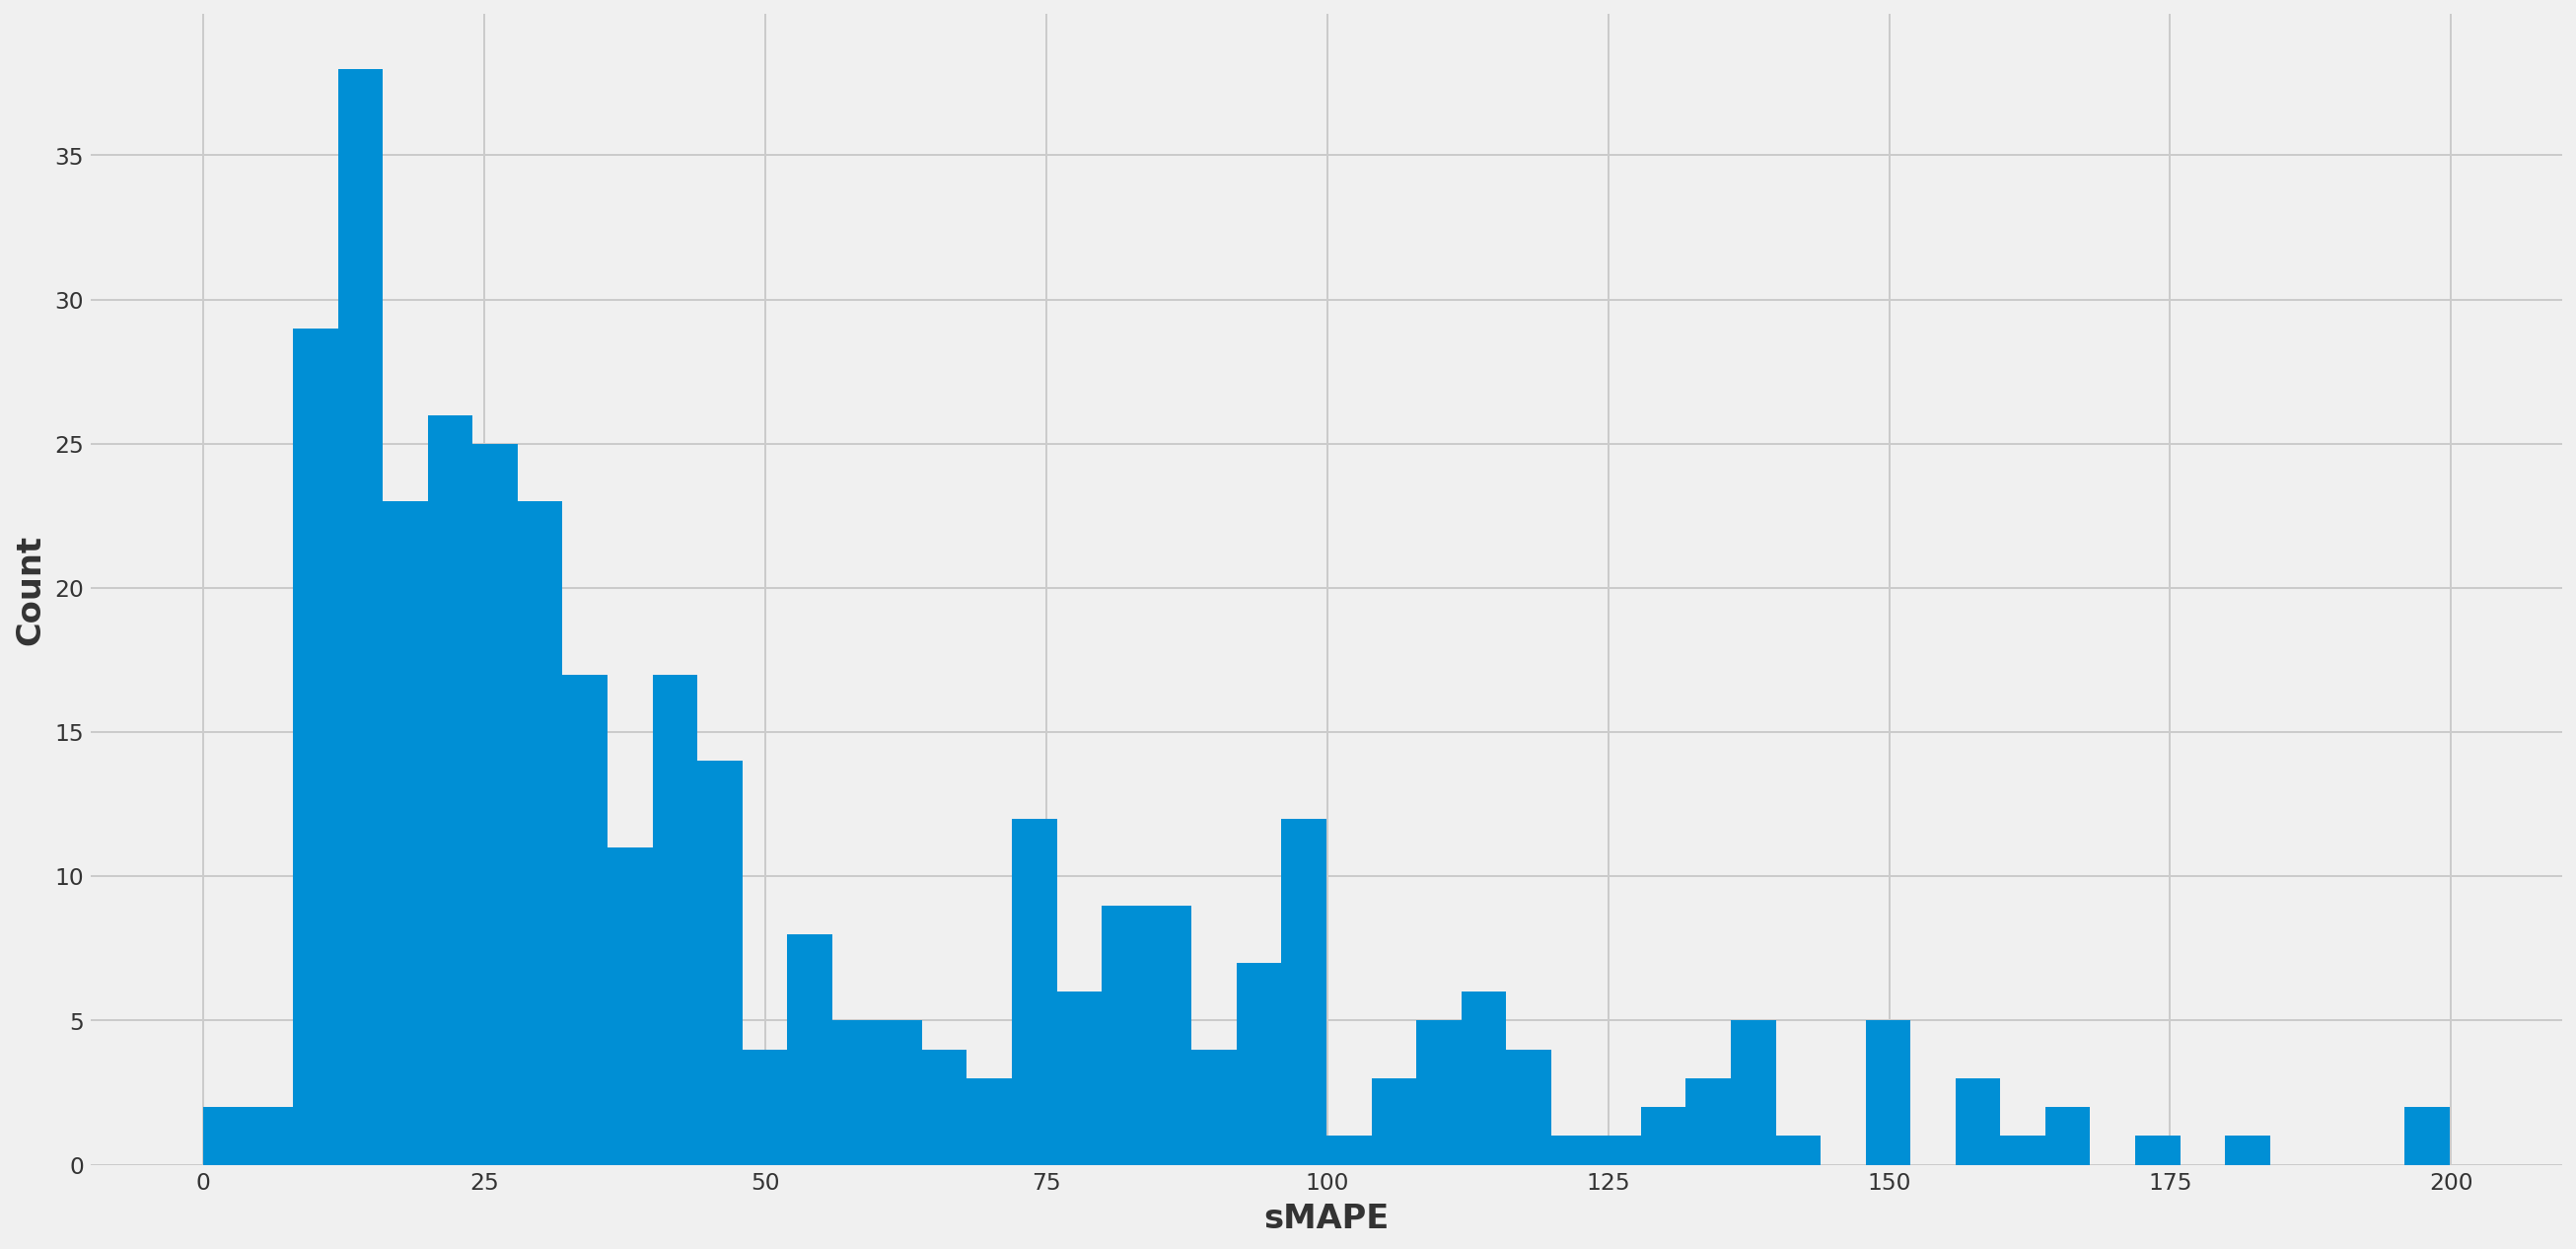

In [15]:
ns_last_smapes, ns_last_elapsed_time  = eval_local_model(air_train_scaled, air_test_scaled, 
                                                                                 CFG.horizon, NaiveSeasonal, K= 12)

What about something a little more bespoke?

  0%|          | 0/362 [00:00<?, ?it/s]

computing sMAPEs...
Avg sMAPE: 56.431 +- 49.785


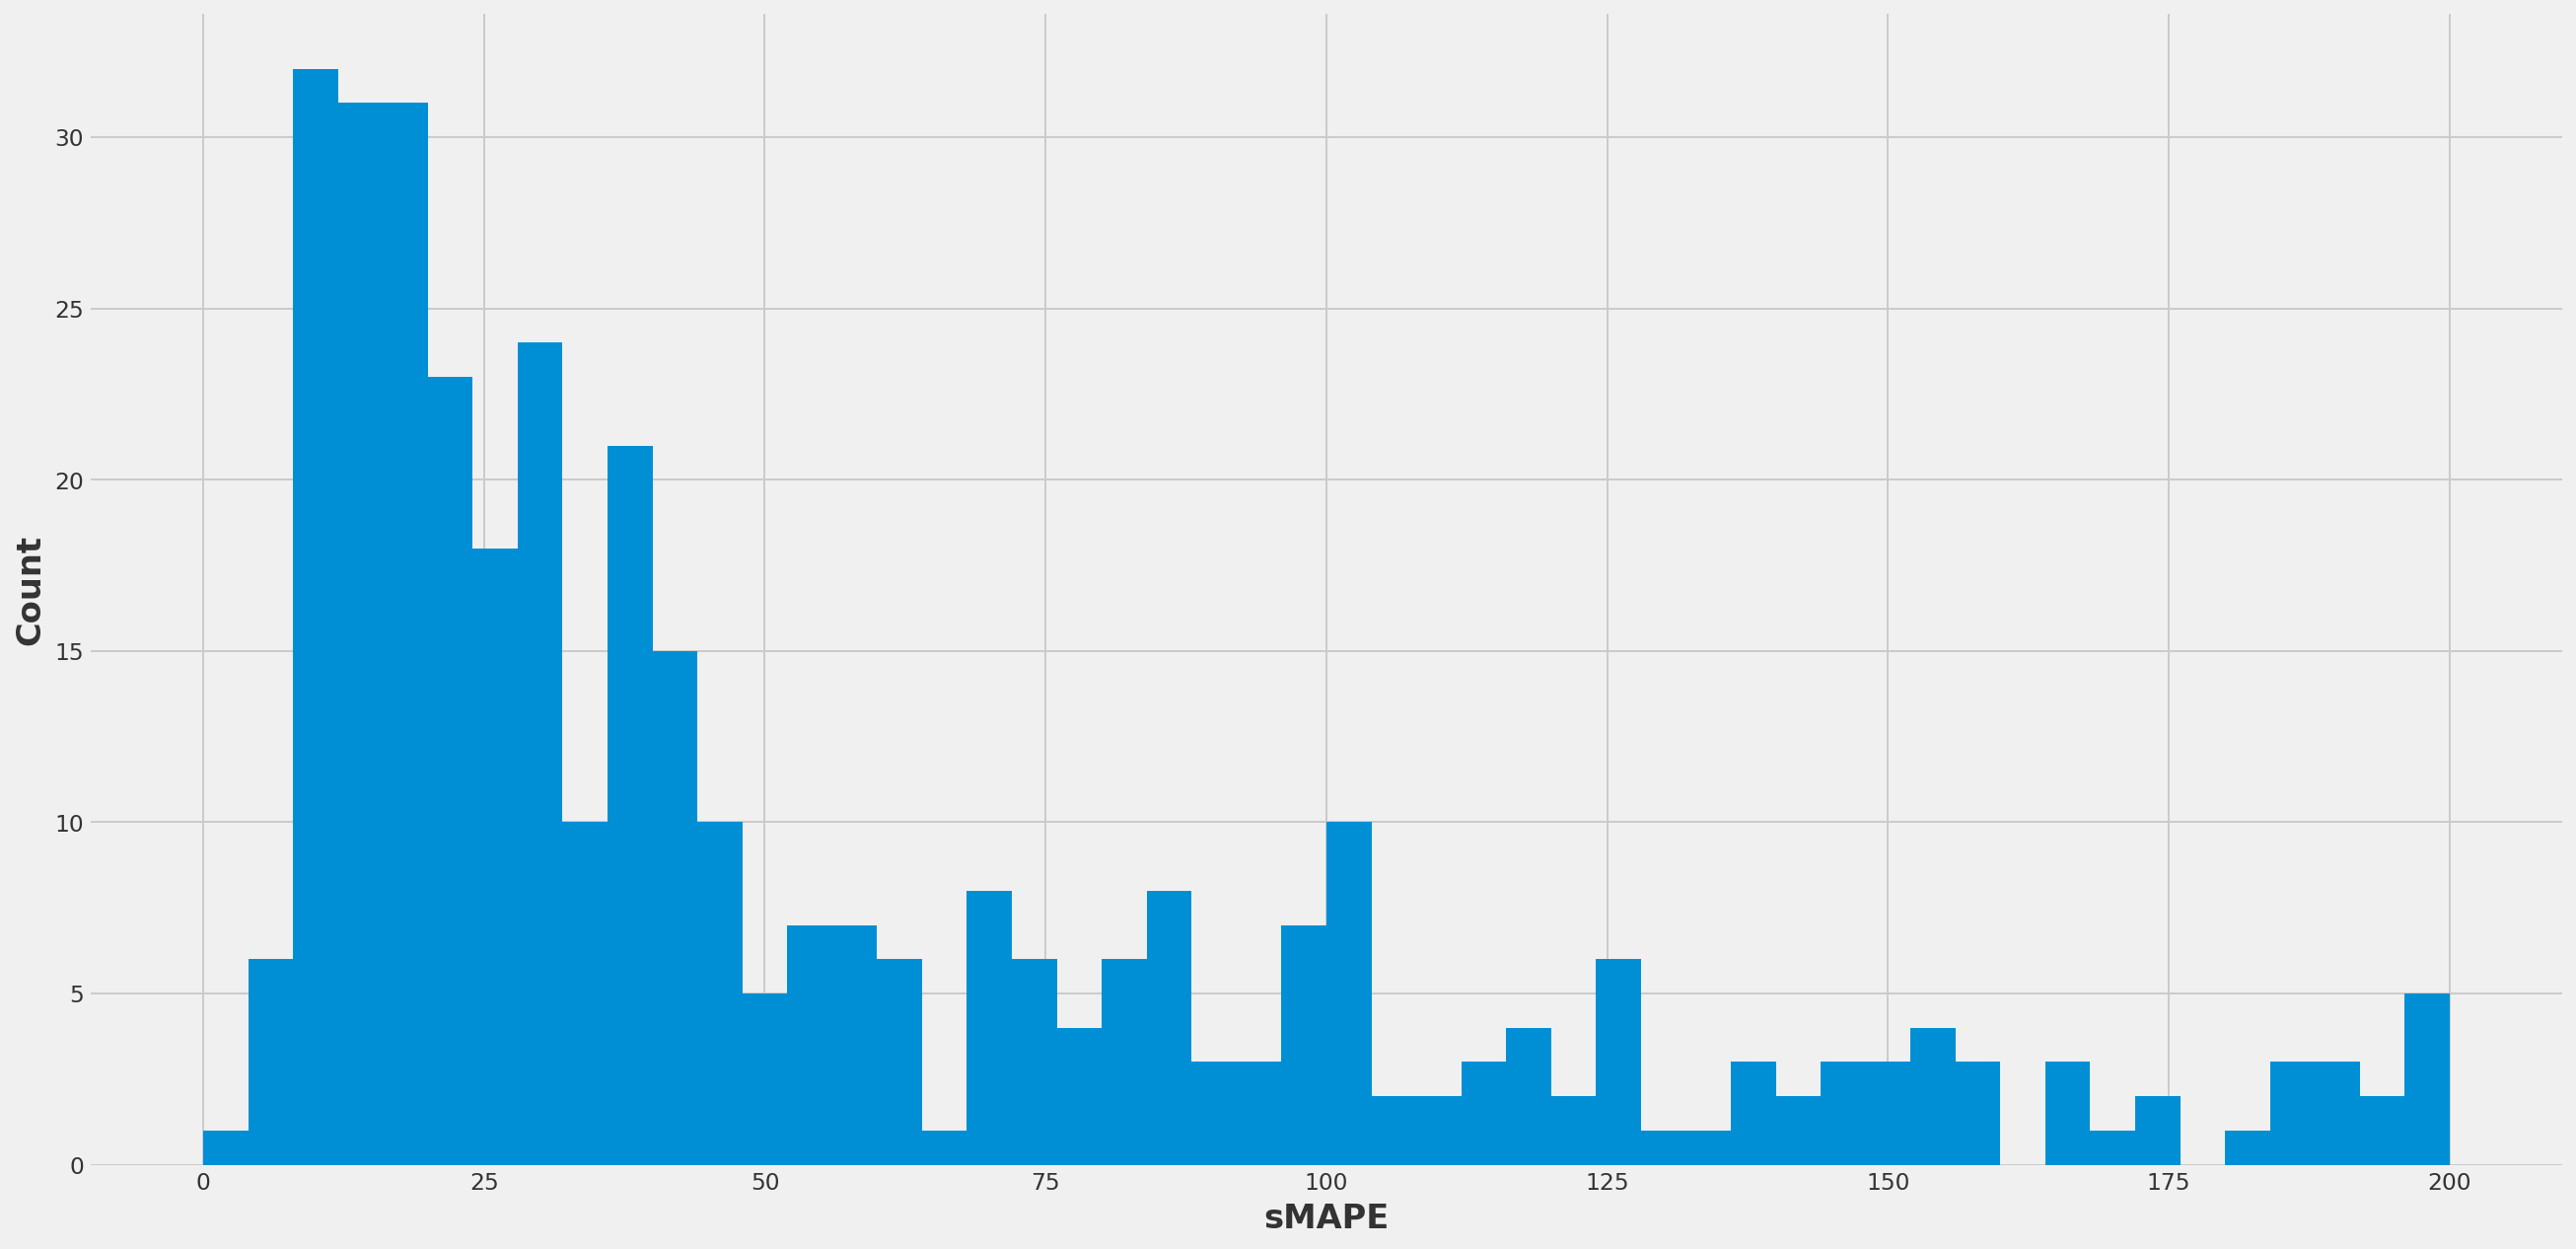

In [16]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)


arima_smapes, arima_elapsed_time = eval_local_model(air_train_scaled, air_test_scaled, CFG.horizon, 
                                                                                 ARIMA, p=12, d=1, q=1)

  0%|          | 0/362 [00:00<?, ?it/s]

computing sMAPEs...
Avg sMAPE: 65.281 +- 56.290


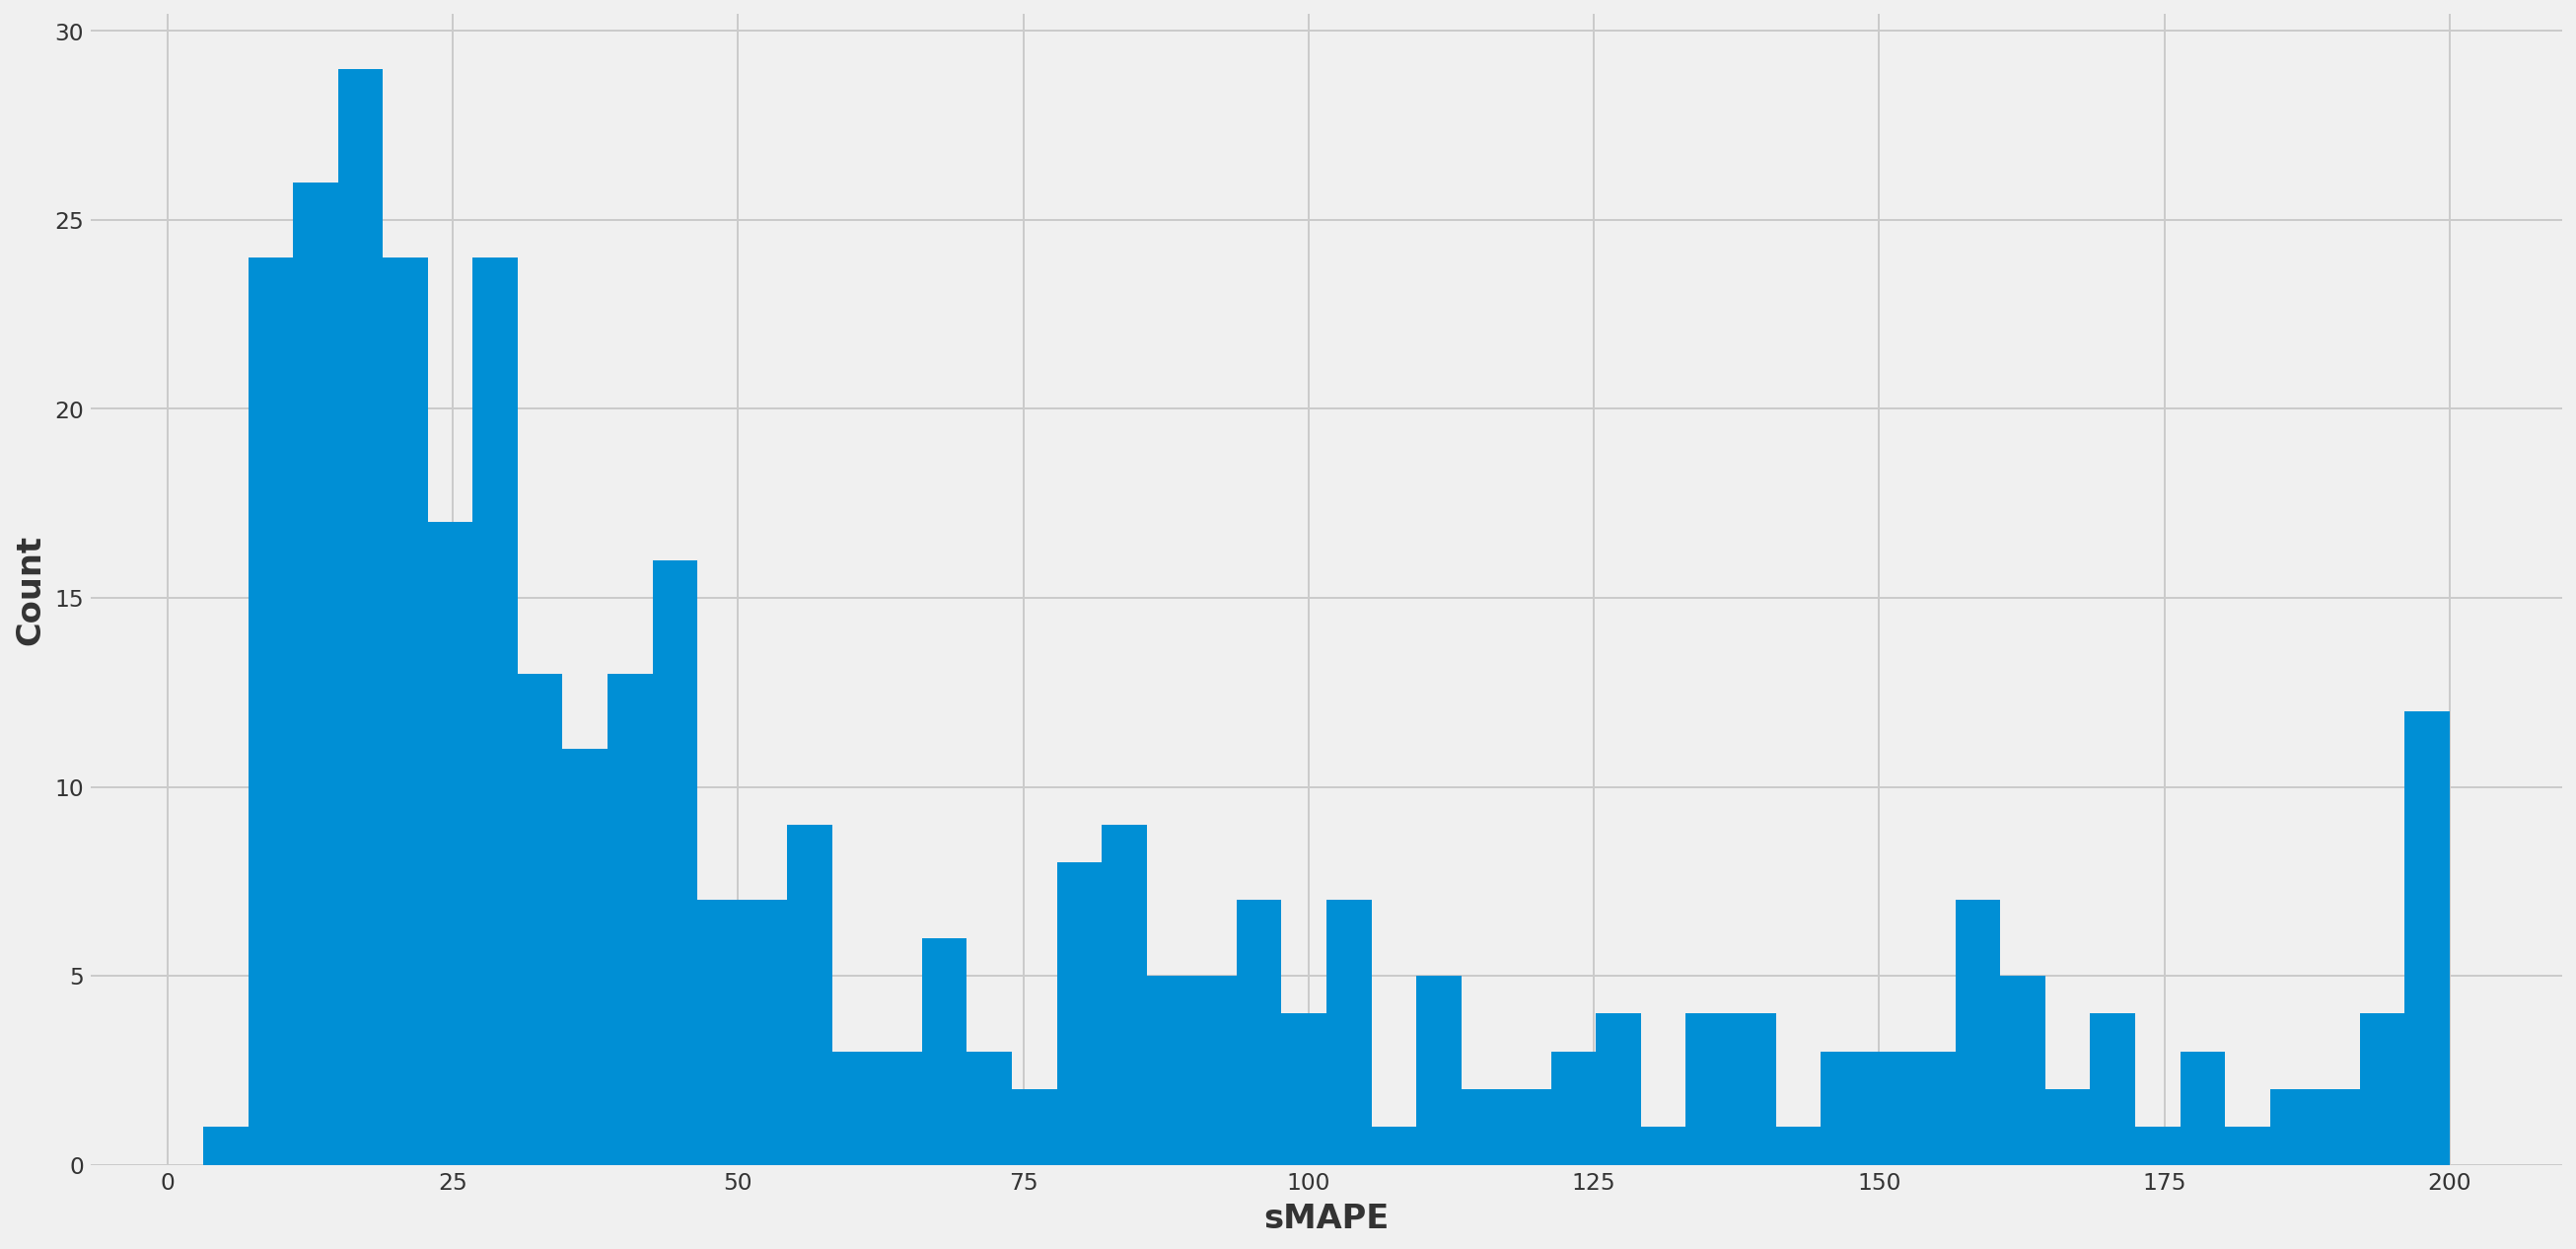

In [17]:
es_smapes, es_elapsed_time = eval_local_model(air_train, air_test,  CFG.horizon, 
                                              ExponentialSmoothing)


Since the individual series tend to be rather short, we focus on vintage models here: the results above give us an indication what to expect; beating `NaiveSeasonal` is not trivial, apparently. 


Let's start exploiting the joint structure in the data, starting with fitting a single model for all series together - effectively first step towards transfer learning.

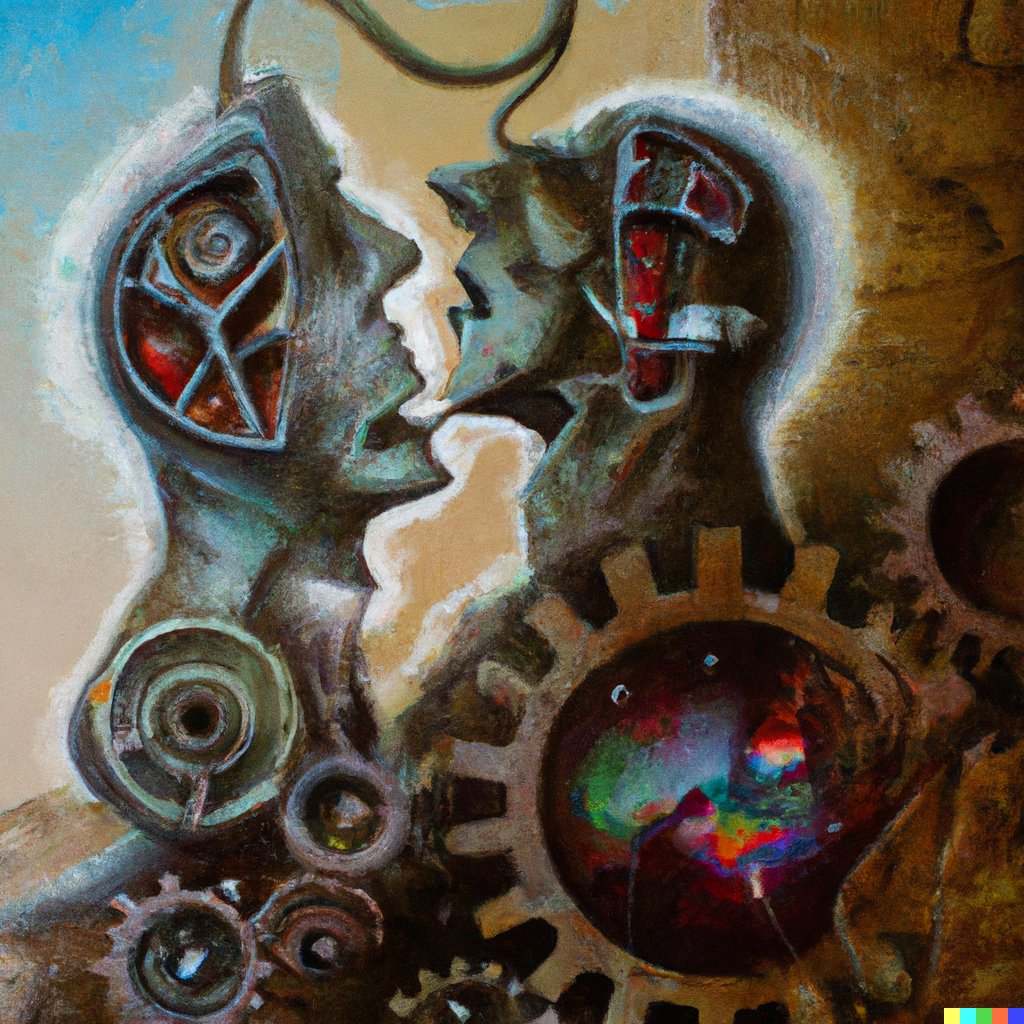

<a id="section-joint"></a>
# Joint model

For our joint model, we will use `NBEATS`, which you might remember from [Episode 9](https://www.kaggle.com/code/konradb/ts-9-hybrid-methods): it's a deep learning architecture, built around something of a hierarchical aggregation of MLP.

In [18]:
from darts.utils.losses import SmapeLoss

# Slicing hyper-params:
IN_LEN = 24
OUT_LEN = 12

# Architecture hyper-params:
NUM_STACKS = 18
NUM_BLOCKS = 3
NUM_LAYERS = 3
LAYER_WIDTH = 180
COEFFS_DIM = 6
LOSS_FN = SmapeLoss()

# Training settings:
LR = 5e-4
BATCH_SIZE = 1024
NUM_EPOCHS = 5


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"


Training: 0it [00:00, ?it/s]

Predicting: 112it [00:00, ?it/s]

computing sMAPEs...
Avg sMAPE: 97.051 +- 42.173


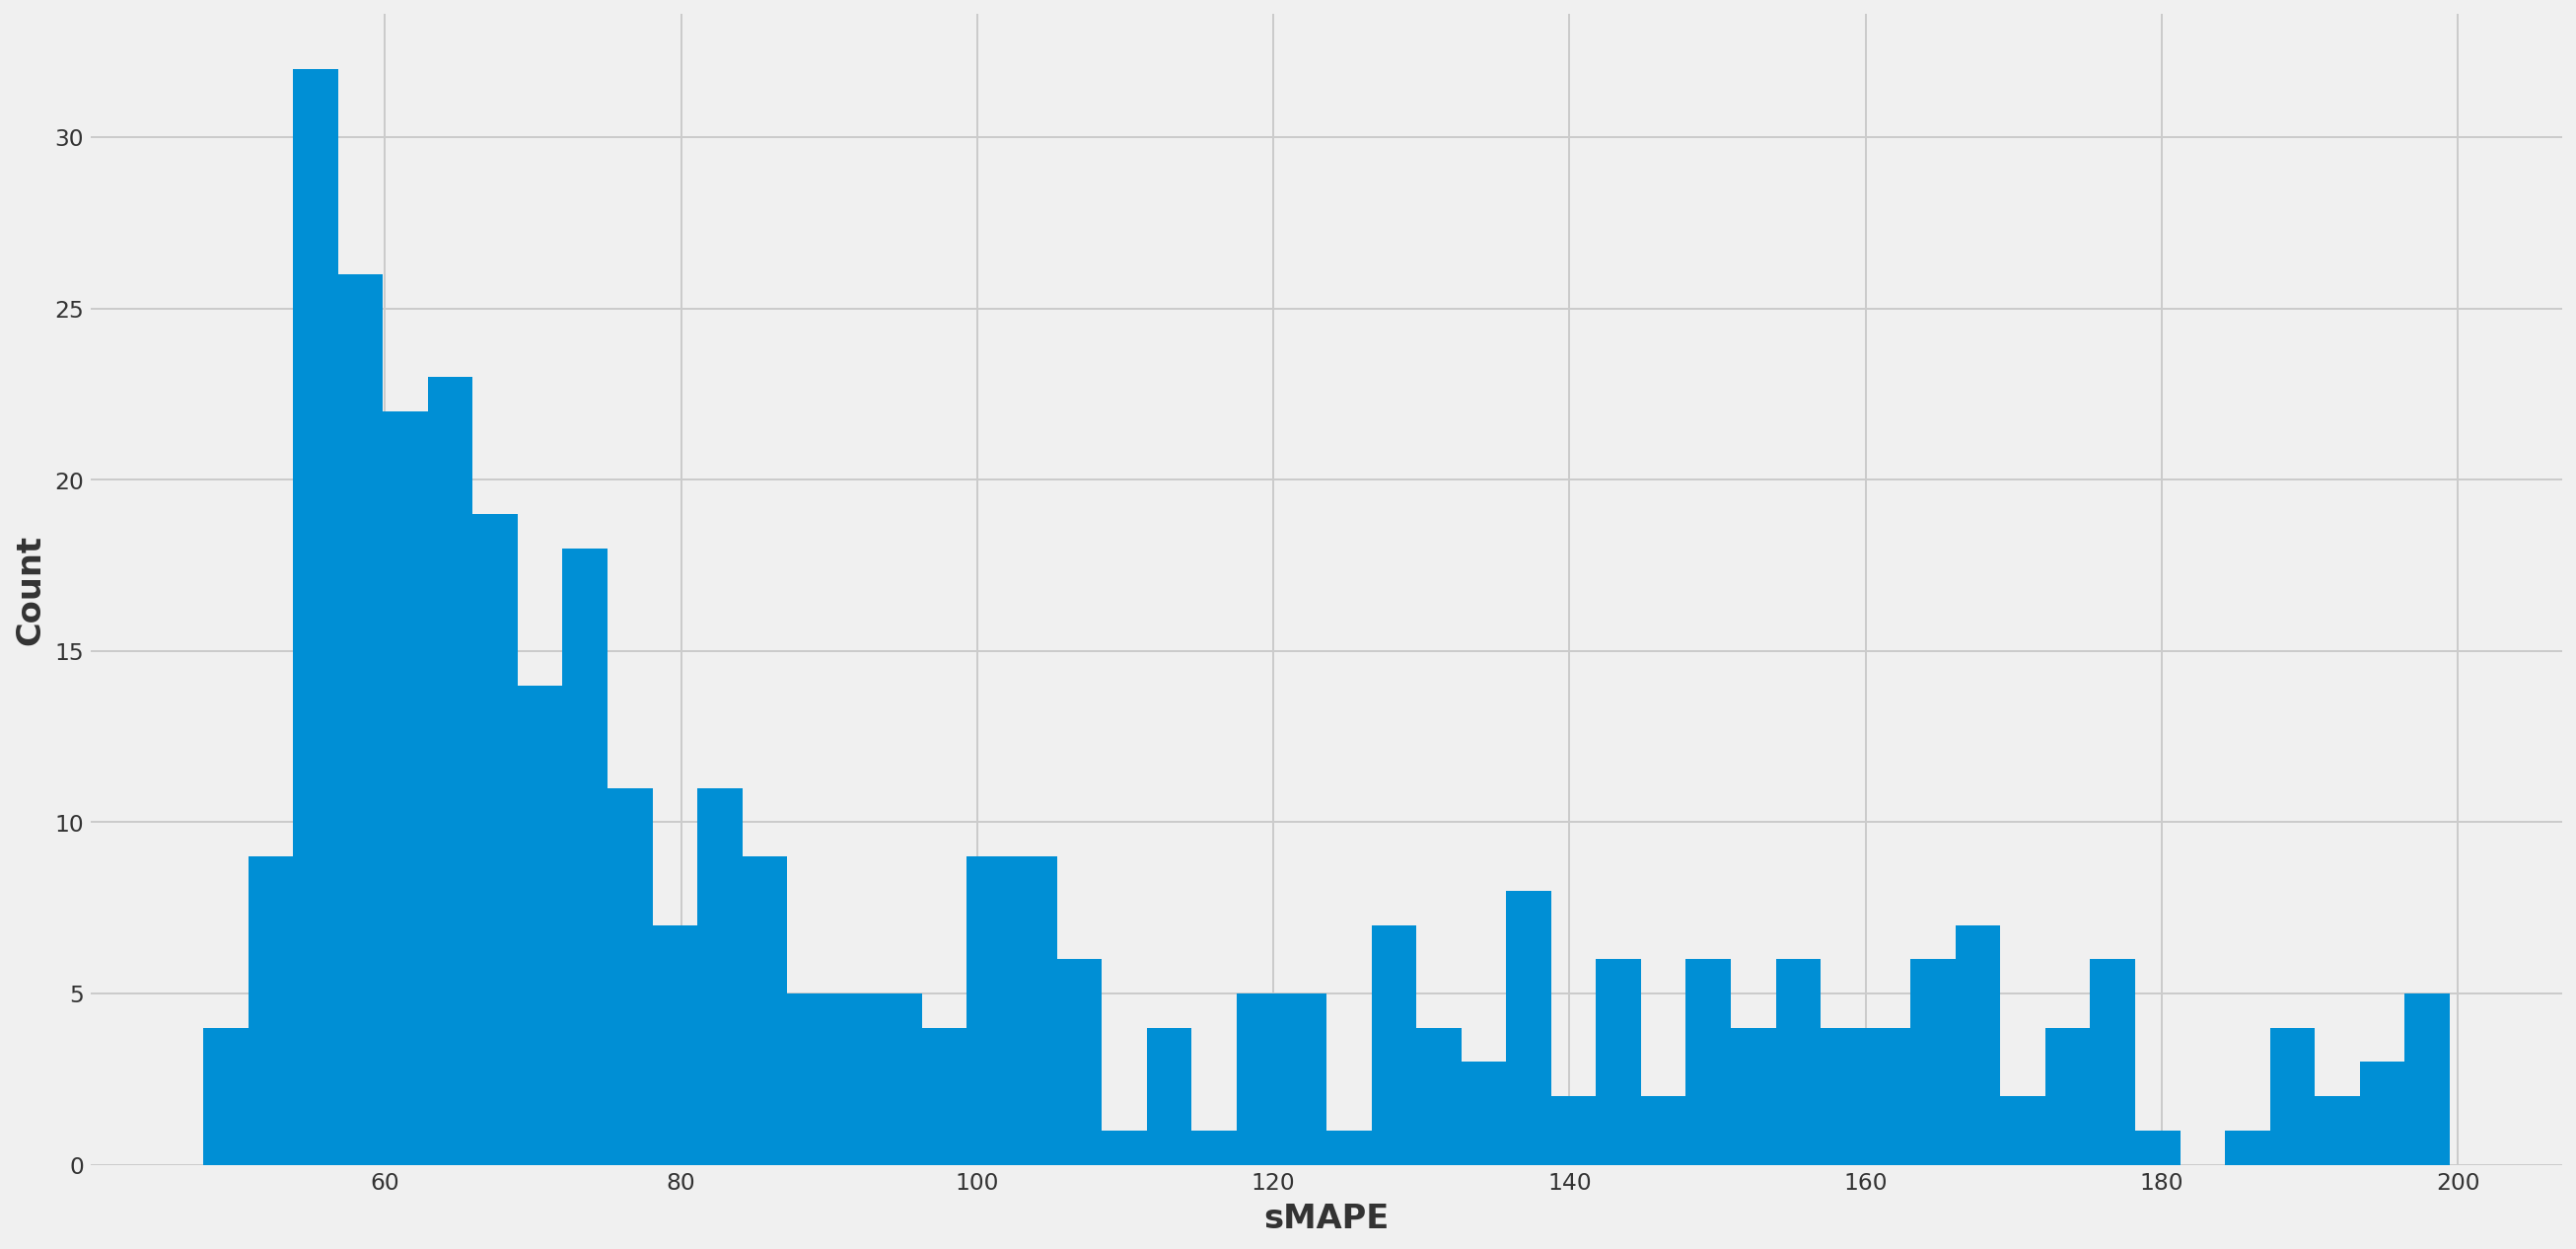

In [19]:
# reproducibility
np.random.seed(42)
torch.manual_seed(42)
start_time = time.time()
nbeats_model_air = NBEATSModel(input_chunk_length=IN_LEN,
                               output_chunk_length=OUT_LEN, 
                               batch_size=BATCH_SIZE,
                               nr_epochs_val_period=1,
                               num_stacks=NUM_STACKS,
                               num_blocks=NUM_BLOCKS,
                               num_layers=NUM_LAYERS,
                               layer_widths=LAYER_WIDTH,
                               expansion_coefficient_dim=COEFFS_DIM,
                               loss_fn=LOSS_FN,
                               optimizer_kwargs={'lr': LR},
                               pl_trainer_kwargs={"enable_progress_bar": True, 
                                                  "accelerator": "gpu",
                                                  "gpus": -1,
                                                  "auto_select_gpus": True},
                               )

nbeats_model_air.fit(air_train_scaled, num_loader_workers=1, epochs=NUM_EPOCHS)

nb_preds = nbeats_model_air.predict(series = air_train_scaled, n = CFG.horizon)
nbeats_elapsed_time = time.time() - start_time
nbeats_smapes = eval_forecasts(nb_preds, air_test_scaled)

In [20]:
def smapes_boxplot(method_to_smapes: Dict[str, List[float]], title: str):
    method_names = []
    smapes = []
    for curr_method_name, curr_smapes in method_to_smapes.items():        
        method_names += [curr_method_name] * len(curr_smapes)
        smapes += curr_smapes
    smapes_df = pd.DataFrame({'Method': method_names, 'sMAPE': smapes})
    plt.figure(figsize=(CFG.img_dim1,CFG.img_dim2), dpi=144)
    ax = sns.boxplot(x="Method", y="sMAPE", data=smapes_df)
    ax.grid(False)
    # Display median score on each box
    medians = smapes_df.groupby(['Method'])['sMAPE'].median().round(decimals=2)
    vertical_offset = smapes_df['sMAPE'].median() * 0.1
    for xtick, name in enumerate(method_to_smapes.keys()):
        
        ax.text(xtick, medians[name] + vertical_offset, medians[name], 
                  horizontalalignment='center', size='x-small', color='w', weight='semibold')
        plt.xticks(rotation=90) 
        plt.title(title) 
        plt.show()
        plt.close()

def elapsed_time_barplot(method_to_elapsed_times: Dict[str, float], title: str):
    elapsed_times_df = pd.DataFrame({'Method': method_to_elapsed_times.keys(), 'Elapsed time [s]': method_to_elapsed_times.values()})
    ax = plt.figure(figsize=(CFG.img_dim1,CFG.img_dim2), dpi=144)
    sns.barplot(x="Method", y="Elapsed time [s]", data=elapsed_times_df)
    plt.xticks(rotation=90) 
    plt.title(title) 
    plt.show()
    plt.close()


<AxesSubplot:>

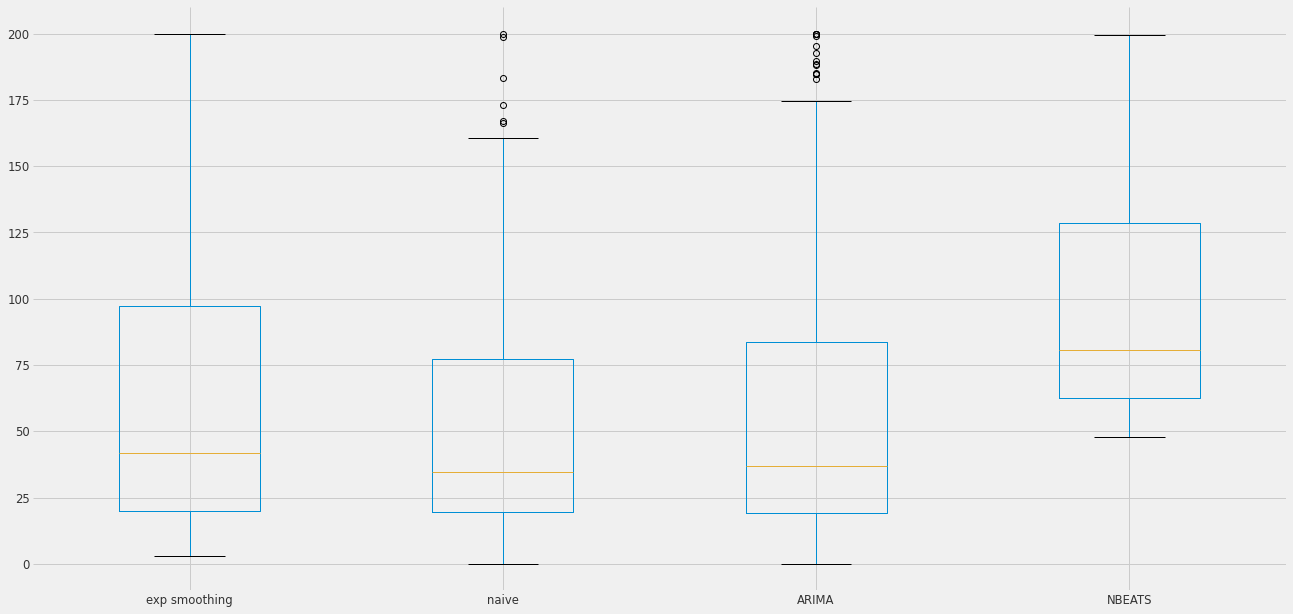

In [21]:
smapes  = pd.DataFrame.from_dict( {'exp smoothing': es_smapes, 'naive': ns_last_smapes,
                                       'ARIMA': arima_smapes,
                                   'NBEATS': nbeats_smapes})

smapes.boxplot()

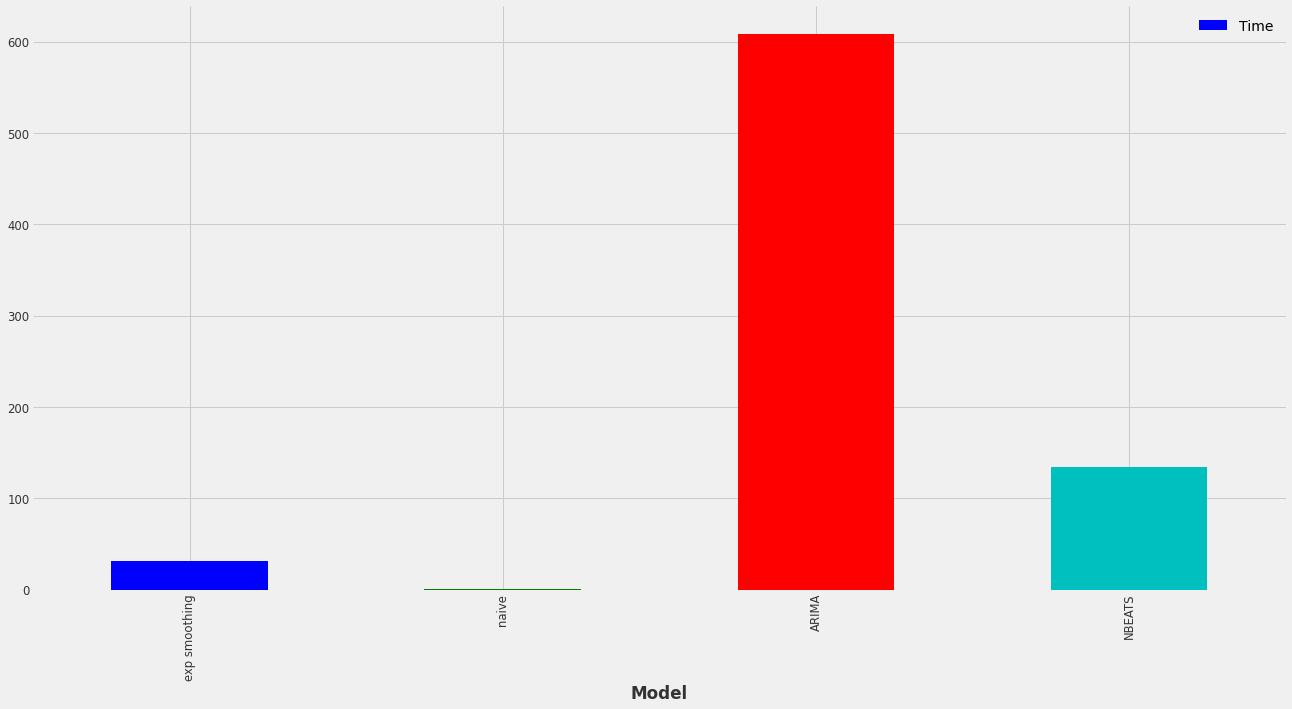

In [22]:
etimes = pd.DataFrame({'Model': ['exp smoothing', 'naive', 'ARIMA', 'NBEATS'],
                        'Time': [es_elapsed_time, ns_last_elapsed_time, arima_elapsed_time,
                                nbeats_elapsed_time]})
bargraph = etimes.plot(kind = 'bar',x = 'Model', y = 'Time', color = ['b', 'g', 'r', 'c'])



A joint model can offer performance on part with the local ones, if not the best of the bunch - although it less dispersed in its results. Can we improve the situation with more data? 

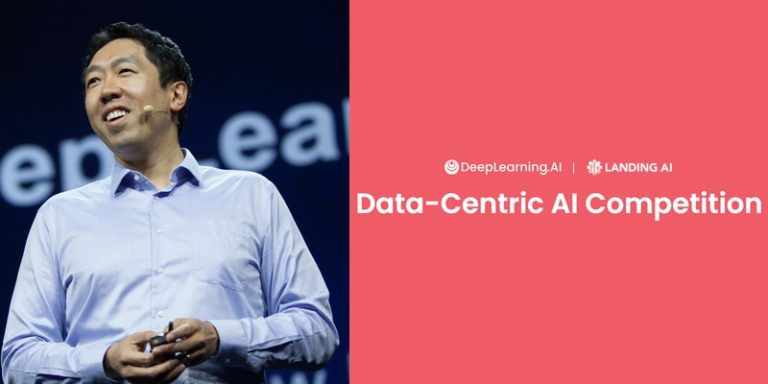

<a id="section-tl1"></a>
# TL: pretraining a time series model

CV models went wild with the ability to pretrain on large amounts of images (Imagenet, Instagram), similar pattern emerged with NLP;  a simple adaptation of this approach to time series involves using a large collection of time series to train our model and then using it for prediction $\rightarrow$ the usual point about downstream task / labeling is moot here.

In [23]:
xdat_m4 = pd.read_csv('../input/m4-forecasting-competition-dataset/Monthly-train.csv')
xdat_m4.drop('V1', axis = 1, inplace = True)
xdat_m4.head(3)

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V2786,V2787,V2788,V2789,V2790,V2791,V2792,V2793,V2794,V2795
0,8000.0,8350.0,8570.0,7700.0,7080.0,6520.0,6070.0,6650.0,6830.0,5710.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2440.0,2490.0,2710.0,2290.0,1960.0,1990.0,1960.0,2530.0,2640.0,2650.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2670.0,2590.0,2784.0,2816.0,2888.0,2906.0,2839.0,2860.0,2798.0,2795.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We proceed in a similar fashion as with the "baseline" model above: 

In [24]:
# create a list of series
m4_series = []

for ii in range(xdat_m4.shape[0]):
    
    # drop the missing values - this can be improved by only dropping contiguous blocks
    xd = xdat_m4.iloc[ii].dropna()

    xseries = TimeSeries.from_values(xd.values)
    
    if len(xseries) > 172:        
        m4_series.append(xseries)

# train / test split

m4_train = [s[: - 72] for s in m4_series]
m4_test = [s[ - 72:] for s in m4_series]



In [25]:
# normalize the data 
scaler_m4 = Scaler(scaler=MaxAbsScaler())
m4_train_scaled: List[TimeSeries] = scaler_m4.fit_transform(m4_train)
m4_test_scaled: List[TimeSeries] = scaler_m4.transform(m4_test)

In [26]:
from darts.utils.losses import SmapeLoss

# Slicing hyper-params:
IN_LEN = 24
OUT_LEN = 12
# Architecture hyper-params:
NUM_STACKS = 18
NUM_BLOCKS = 3
NUM_LAYERS = 3
LAYER_WIDTH = 180
COEFFS_DIM = 6
LOSS_FN = SmapeLoss()
# Training settings:
LR = 5e-4
BATCH_SIZE = 1024
MAX_SAMPLES_PER_TS = 64
NUM_EPOCHS = 5


In [27]:
# reproducibility
np.random.seed(42)
torch.manual_seed(42)

nbeats_model_m4 = NBEATSModel(input_chunk_length=IN_LEN,
                               output_chunk_length=OUT_LEN, 
                               batch_size=BATCH_SIZE,
                               nr_epochs_val_period=1,
                               num_stacks=NUM_STACKS,
                               num_blocks=NUM_BLOCKS,
                               num_layers=NUM_LAYERS,
                               layer_widths=LAYER_WIDTH,
                               expansion_coefficient_dim=COEFFS_DIM,
                               loss_fn=LOSS_FN,
                               optimizer_kwargs={'lr': LR},
                               pl_trainer_kwargs={"enable_progress_bar": True, 
                                                  "accelerator": "gpu",
                                                  "gpus": -1,
                                                  "auto_select_gpus": True},
                               )



In [28]:
nbeats_model_m4.fit(m4_train_scaled,
                    num_loader_workers=1,
                    max_samples_per_ts=MAX_SAMPLES_PER_TS,
                    epochs=NUM_EPOCHS, val_series = m4_test_scaled,
                    verbose = True
                   )


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 1811it [00:00, ?it/s]

computing sMAPEs...
Avg sMAPE: 56.998 +- 49.393


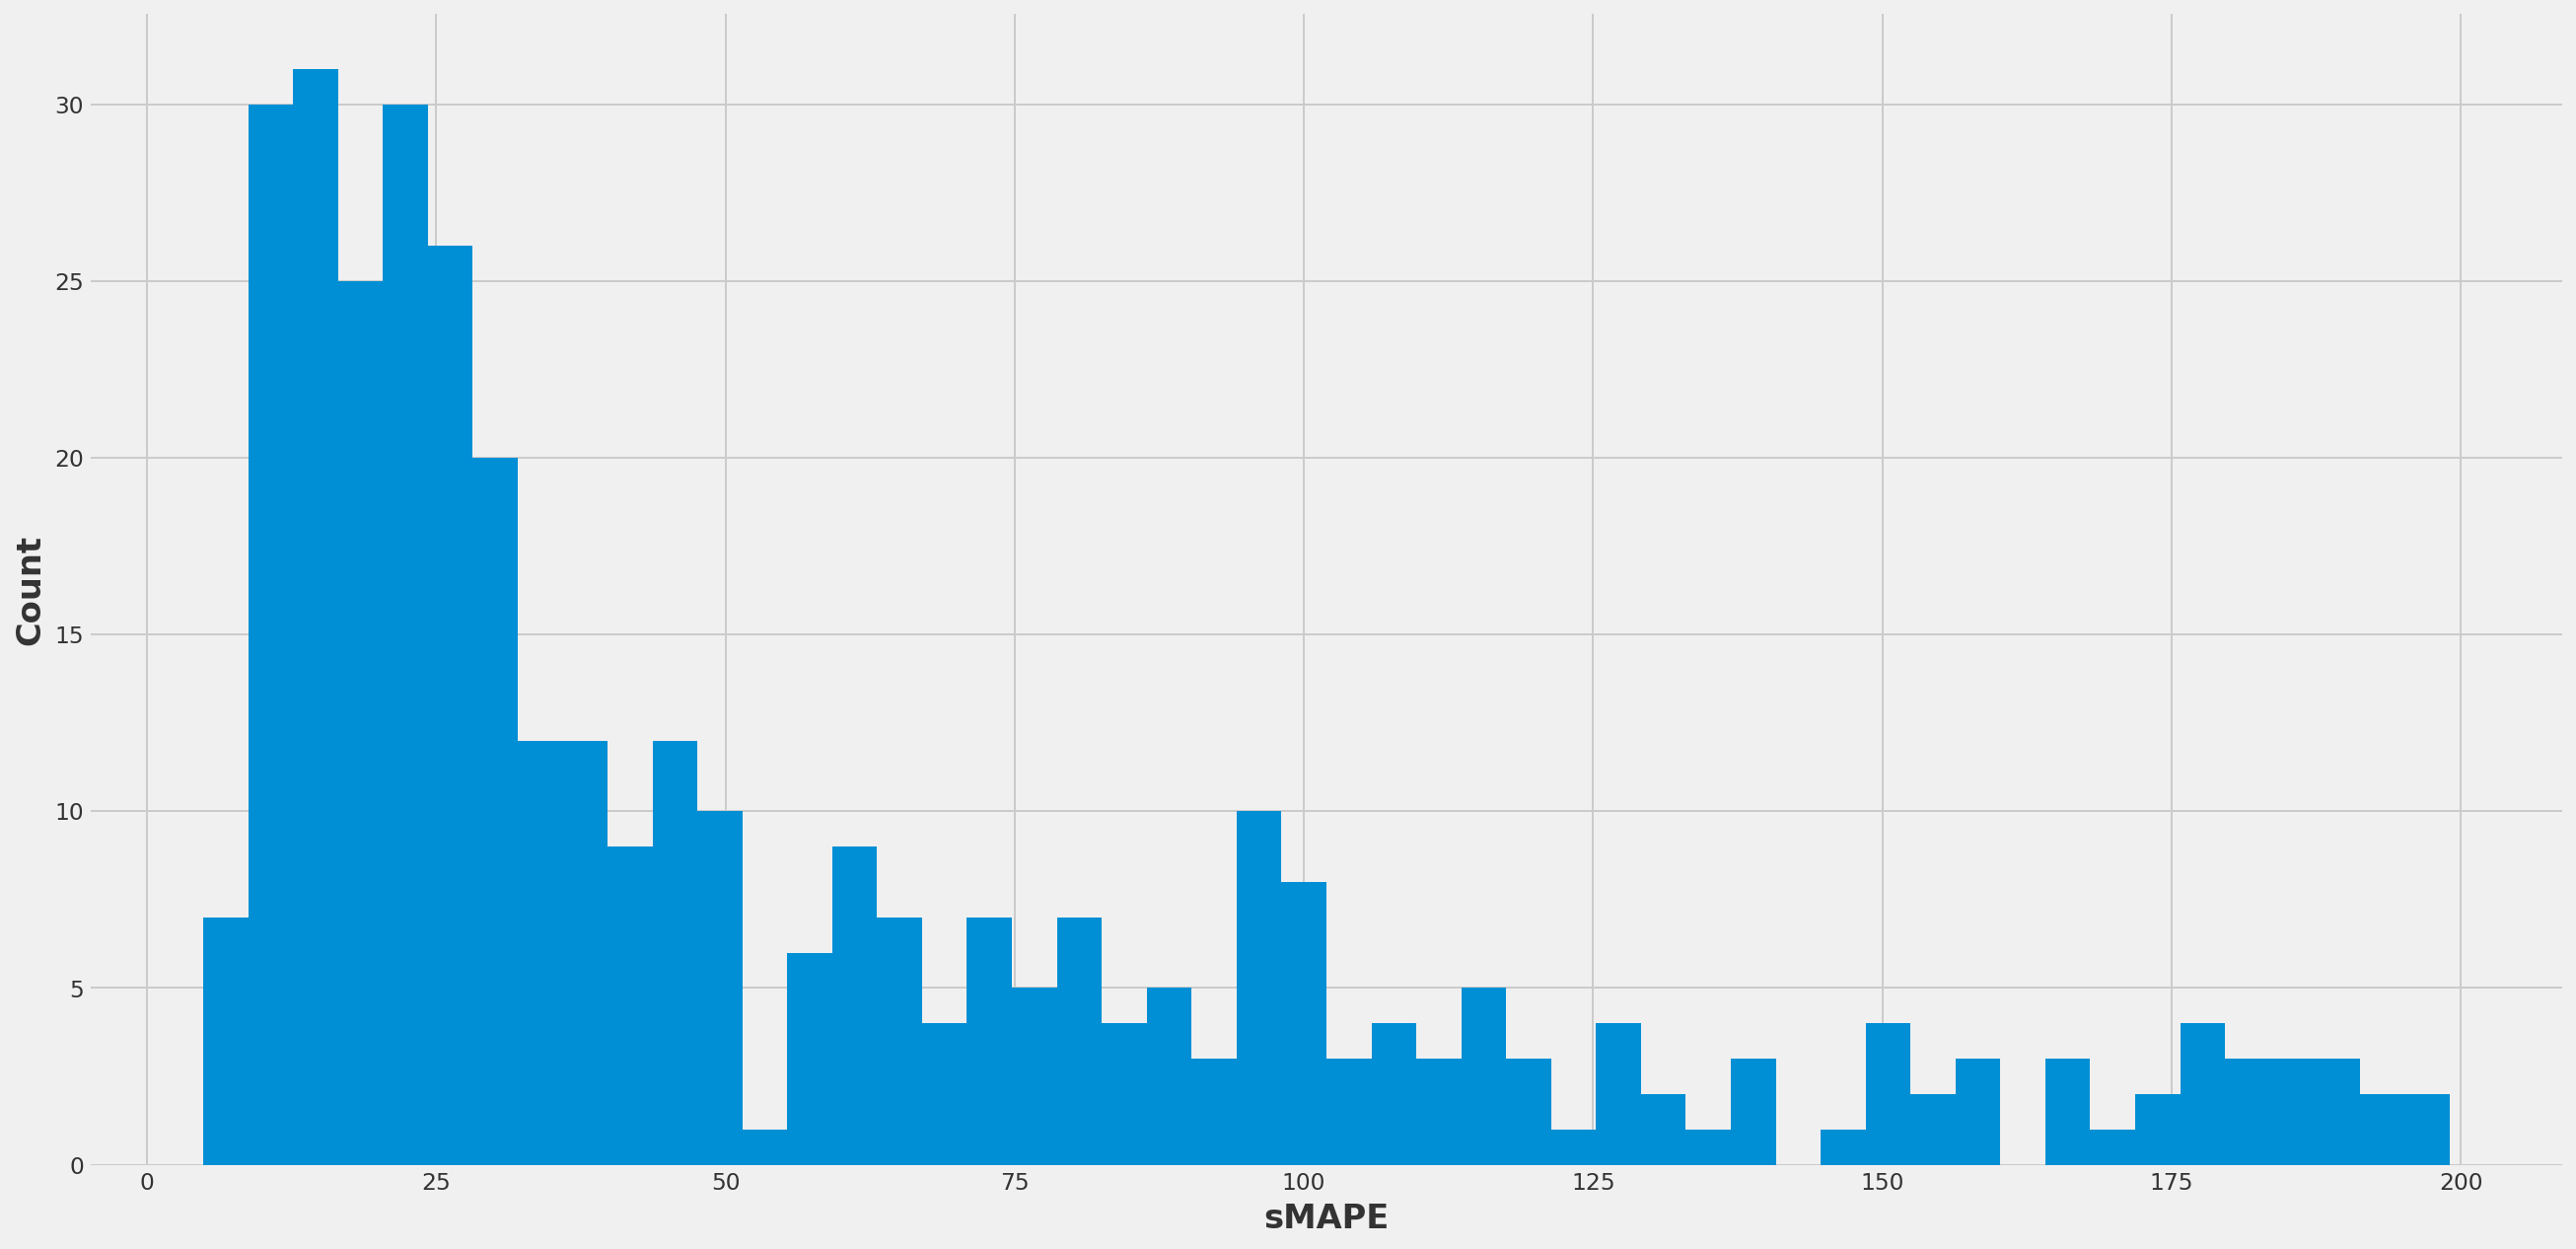

In [29]:
start_time = time.time()
nbm4_preds = nbeats_model_m4.predict(series = air_train_scaled, n = CFG.horizon)
nbm4_elapsed_time = time.time() - start_time
nbm4_smapes = eval_forecasts(nbm4_preds, air_test_scaled)

<AxesSubplot:>

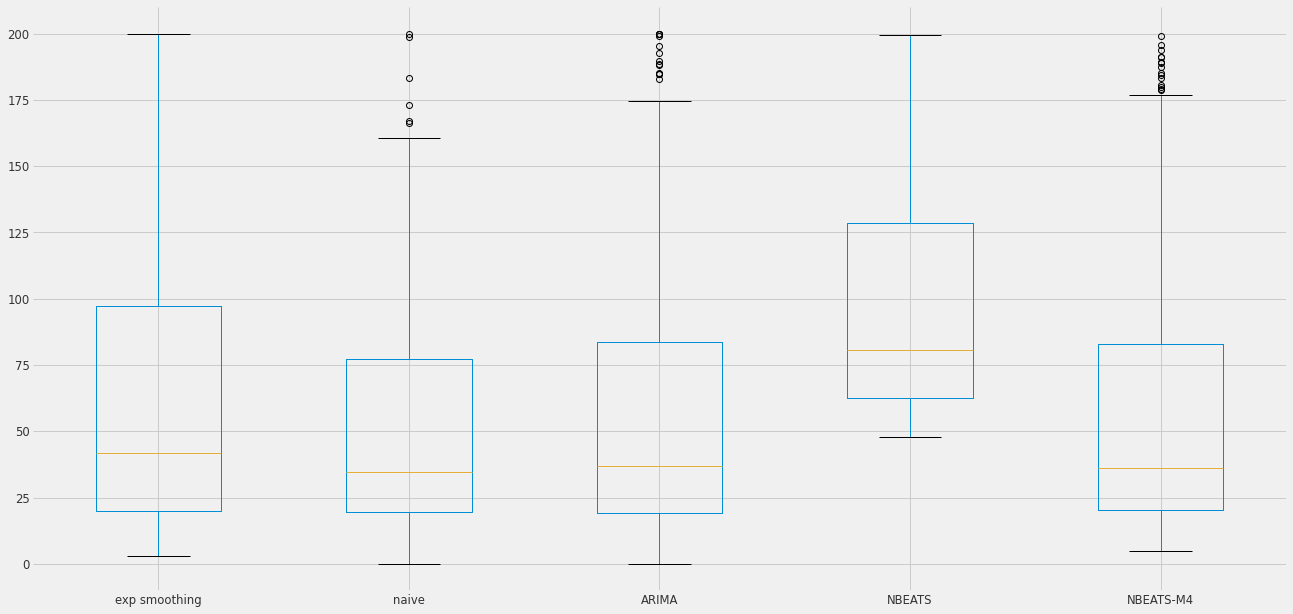

In [30]:
smapes  = pd.DataFrame.from_dict( {'exp smoothing': es_smapes, 'naive': ns_last_smapes,
                                       'ARIMA': arima_smapes,   'NBEATS': nbeats_smapes,
                                       'NBEATS-M4': nbm4_smapes
                                    })

smapes.boxplot()

As you can see from the graph above, NBEATS pretrained on M4 is comparable in performance with the individual models per series - **despite the fact it was not trained on any of the airline data**. What about execution time?

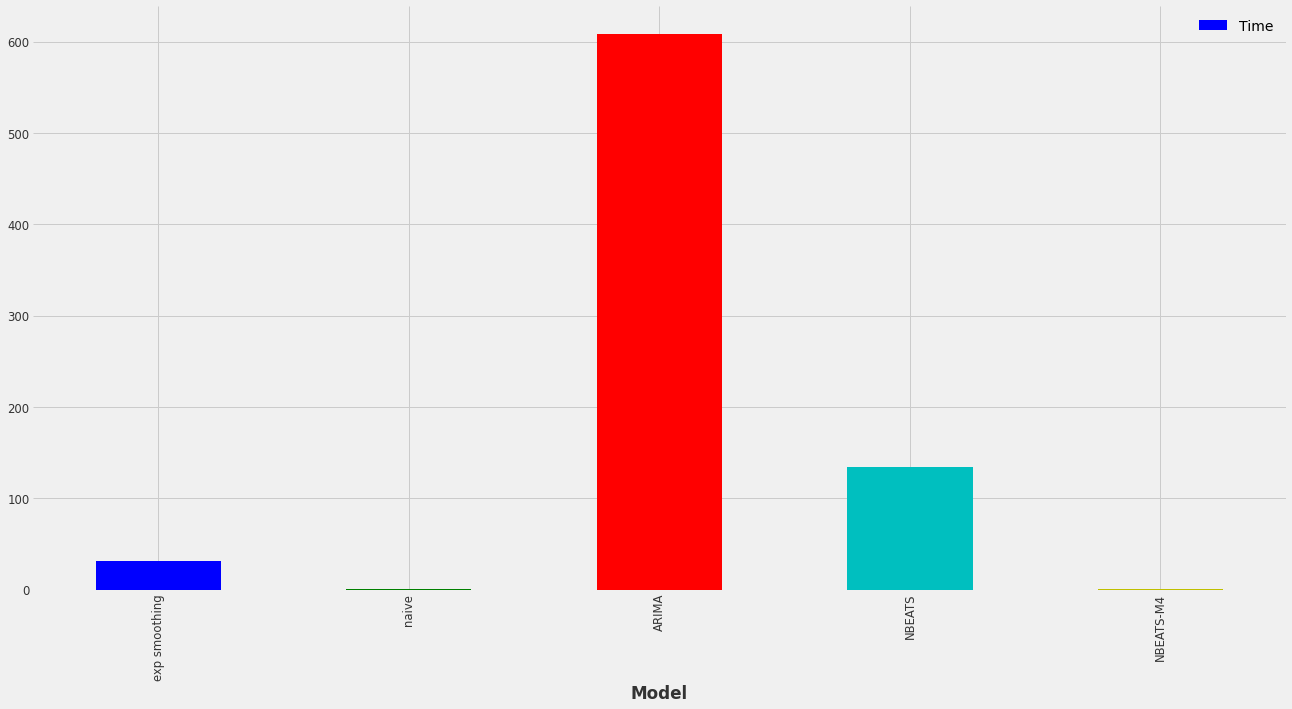

In [31]:
etimes = pd.DataFrame({'Model': ['exp smoothing', 'naive', 'ARIMA', 'NBEATS', 'NBEATS-M4'],
                        'Time': [es_elapsed_time, ns_last_elapsed_time, arima_elapsed_time,
                                nbeats_elapsed_time, nbm4_elapsed_time]})
bargraph = etimes.plot(kind = 'bar',x = 'Model', y = 'Time', color = ['b', 'g', 'r', 'c', 'y'])

Not only does it achieve performance (which can undoubtedly be improved with longer training / hyperparameters tuning), but it's also blazing fast - we don't need to train anything specifically for this application. 


<a id="section-tl2"></a>
# TL: the tinkering 

In the previous section we re-used the same architecture fitted on a dataset with the same frequency as the target one. While those contraints are not very harsh, let us see how we can become more flexible in our transfer learning adventure. We will use the data from the [M5 Competition](https://www.kaggle.com/c/m5-forecasting-accuracy) competition  and recycle code bits from [Episode 6](https://www.kaggle.com/code/konradb/ts-6-deep-learning-for-ts-rnn-and-friends/):

In [32]:
## prepare the data
calendar_df = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv', parse_dates=['date'])
calendar_df = calendar_df.loc[:, ['date', 'wm_yr_wk', 'd']]
df = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_evaluation.csv')
df = df.loc[df.item_id== CFG.which_art]
df_T = df.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
df_T.drop(columns=['id'], inplace=True)

sales_df = df_T.merge(calendar_df, left_on='variable', right_on='d', how='left')
sales_df.rename(columns={'value': 'sales_qty'}, inplace=True)
df = sales_df.loc[sales_df.date >= CFG.start_point, ['date', 'store_id', 'sales_qty']]
df['state_id'] = df['store_id'].str[:2]

# create the long format matrix: individual stores
df_ind = df.groupby(['date', 'store_id'])[['sales_qty']].sum()
df_ind.reset_index(inplace=True)
df_ind = df_ind.T.reset_index(drop=True).T
df_ind.columns = ['ds', 'unique_id', 'sales']

df_ind.sort_values(by = ['unique_id','ds'], inplace = True)



In [33]:
## split into training and holdout
xdat = df_ind.pivot(index='ds', columns='unique_id', values='sales')

xtrain, xtest = xdat.iloc[:-(2 * CFG.lookahead + CFG.lookback)], xdat.iloc[-(2 * CFG.lookahead + CFG.lookback):]
x0, x1 = xtrain.iloc[:-(2 * CFG.lookahead + CFG.lookback)], xtrain.iloc[- (2 * CFG.lookahead + CFG.lookback):]

# scale / normalize the columns
xcols = xtrain.columns

RS = RobustScaler()
RS.fit(xtrain)

xtrain = RS.fit_transform(xtrain.to_numpy())
xtrain = pd.DataFrame(xtrain, columns= xcols)

xtest = RS.transform(xtest.to_numpy())
xtest = pd.DataFrame(xtest, columns= xcols)

In [34]:
## format into LSTM-friendly (so that it also works with the M4 data format)
def create_dataset(dataset, look_back, look_ahead):
    xdat, ydat = [], []
    for f in dataset.columns:
        for i in range(len(dataset) - look_back -look_ahead):
            xdat.append(dataset.iloc[i:i+ look_back][f])
            ydat.append(dataset.iloc[i+ look_back : i + look_back + look_ahead][f])
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead)
    xdat = xdat.reshape(-1, look_back, 1)
    return xdat.astype(np.float32), ydat.astype(np.float32)

In [35]:
x0, y0 = create_dataset(dataset = x0, look_back = CFG.lookback, look_ahead = CFG.lookahead)
x1, y1 = create_dataset(dataset = x1, look_back = CFG.lookback, look_ahead = CFG.lookahead)

xtrain, ytrain = create_dataset(dataset = xtrain, look_back = CFG.lookback, look_ahead = CFG.lookahead)
xtest, ytest = create_dataset(dataset = xtest, look_back = CFG.lookback, look_ahead = CFG.lookahead)

Try a simple architecture for the model we will crash test across datasets:

In [36]:
def create_model(out_dim):    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
base_model = create_model(out_dim = CFG.lookahead)

2022-10-11 21:50:24.055513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 21:50:24.056825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 21:50:24.057590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 21:50:24.059078: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [37]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 10)          120       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dense (Dense)                (None, 14)                154       
Total params: 484
Trainable params: 484
Non-trainable params: 0
_________________________________________________________________


In [38]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

base_model.fit(x0, y0, validation_data=(x1, y1), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

Epoch 1/10


2022-10-11 21:50:24.802021: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


70/70 [==============================] - 15s 200ms/step - loss: 4.8633 - val_loss: 4.3838
Epoch 2/10
70/70 [==============================] - 13s 188ms/step - loss: 3.8319 - val_loss: 3.9571
Epoch 3/10
70/70 [==============================] - 14s 200ms/step - loss: 3.5713 - val_loss: 3.8595
Epoch 4/10
70/70 [==============================] - 13s 185ms/step - loss: 3.4936 - val_loss: 3.8164
Epoch 5/10
70/70 [==============================] - 13s 190ms/step - loss: 3.4493 - val_loss: 3.7696
Epoch 6/10
70/70 [==============================] - 14s 195ms/step - loss: 3.4044 - val_loss: 3.6821
Epoch 7/10
70/70 [==============================] - 13s 190ms/step - loss: 3.3359 - val_loss: 3.5892
Epoch 8/10
70/70 [==============================] - 14s 200ms/step - loss: 3.2382 - val_loss: 3.4248
Epoch 9/10
70/70 [==============================] - 13s 187ms/step - loss: 3.1606 - val_loss: 3.4225
Epoch 10/10
70/70 [==============================] - 14s 198ms/step - loss: 3.1311 - val_loss: 3.4135


The main reason for this part is to get a feel how many epochs are necessary - seems like 10 are fine. Let's fit the model on the complete dataset now: 

In [39]:
# fit on complete training data
base_model = create_model(out_dim = CFG.lookahead)
base_model.fit(xtrain, ytrain,  epochs = CFG.nepochs, batch_size = CFG.bsize)

Epoch 1/10
93/93 [==============================] - 19s 189ms/step - loss: 1.0611
Epoch 2/10
93/93 [==============================] - 18s 198ms/step - loss: 0.9317
Epoch 3/10
93/93 [==============================] - 18s 197ms/step - loss: 0.9137
Epoch 4/10
93/93 [==============================] - 17s 184ms/step - loss: 0.9034
Epoch 5/10
93/93 [==============================] - 18s 198ms/step - loss: 0.8971
Epoch 6/10
93/93 [==============================] - 18s 190ms/step - loss: 0.8911
Epoch 7/10
93/93 [==============================] - 18s 196ms/step - loss: 0.8875
Epoch 8/10
93/93 [==============================] - 18s 189ms/step - loss: 0.8836
Epoch 9/10
93/93 [==============================] - 18s 196ms/step - loss: 0.8803
Epoch 10/10
93/93 [==============================] - 17s 186ms/step - loss: 0.8754


Predict on the holdout set, with necessary reshaping (to ensure inverse normalization works):

In [40]:
# predict on holdout
ypred_base = base_model.predict(xtest)

ypred_base = np.reshape(ypred_base.T, (-1,10), order = 'F')
ypred_base = RS.inverse_transform(ypred_base)

ytest = np.reshape(ytest.T, (-1,10), order = 'F')
ytest = RS.inverse_transform(ytest)

In [41]:
from sklearn.metrics import mean_squared_error as mse


def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

base_error = my_rmse(ytest, ypred_base)
print(base_error)

1.5129


This gives us the base error rate. What if we train the model on the M4 dataset first (using daily series so we capture similar types of patterns)?

In [42]:
m4dat = pd.read_csv('../input/m4-forecasting-competition-dataset/Daily-train.csv', nrows= 500)
m4dat.drop('V1', axis = 1, inplace = True)
# there are more elegant ways, I know...
m4dat.dropna(axis = 1, how = 'any', inplace = True)
print(m4dat.shape)

xcols2 = m4dat.columns

RS2 = RobustScaler()
RS2.fit(m4dat)

m4dat = RS2.fit_transform(m4dat.to_numpy())
m4dat = pd.DataFrame(m4dat, columns= xcols2)

m4_model = create_model(out_dim = CFG.lookahead)

m4_x, m4_y = create_dataset(dataset = m4dat, look_back = CFG.lookback, look_ahead = CFG.lookahead)

(500, 97)


In [43]:
m4_model.fit(m4_x, m4_y,  epochs = 5, batch_size = CFG.bsize)

Epoch 1/5
555/555 [==============================] - 107s 191ms/step - loss: 0.2218
Epoch 2/5
555/555 [==============================] - 107s 194ms/step - loss: 0.1675
Epoch 3/5
555/555 [==============================] - 105s 189ms/step - loss: 0.1481
Epoch 4/5
555/555 [==============================] - 105s 190ms/step - loss: 0.1410
Epoch 5/5
555/555 [==============================] - 106s 191ms/step - loss: 0.1396


In [44]:
# predict on holdout
ypred_m4 = m4_model.predict(xtest)

ypred_m4 = np.reshape(ypred_m4.T, (-1,10), order = 'F')
ypred_m4 = RS.inverse_transform(ypred_m4)

In [45]:
pretrain_error = my_rmse(ytest, ypred_m4)
print(pretrain_error)

1.6652


Unlike the airline dataset case in the previous section, this is solidly worse than the "baseline" model - reasons can include architecture simplicity (we just don't learn enough with two small layers) or the fact that difference in domains does actually matter in this instance. Proper investigation is outside the scope of this notebook, so let's instead do something we have not tried and finetune the pretrained model (~ moving from zero- to few-shot learning).

In [46]:
m4_model.fit(xtrain, ytrain,
                  epochs = 5, batch_size = CFG.bsize)

Epoch 1/5
93/93 [==============================] - 17s 181ms/step - loss: 0.9363
Epoch 2/5
93/93 [==============================] - 19s 200ms/step - loss: 0.9110
Epoch 3/5
93/93 [==============================] - 17s 183ms/step - loss: 0.9074
Epoch 4/5
93/93 [==============================] - 18s 198ms/step - loss: 0.9041
Epoch 5/5
93/93 [==============================] - 18s 194ms/step - loss: 0.9017


In [47]:
# predict on holdout
ypred_m4f = m4_model.predict(xtest)

ypred_m4f = np.reshape(ypred_m4f.T, (-1,10), order = 'F')
ypred_m4f = RS.inverse_transform(ypred_m4f)

In [48]:
finetune_error = my_rmse(ytest, ypred_m4f)
print(my_rmse(ytest, ypred_m4f))

1.5498


In [49]:
print('baseline: ' + str(base_error))
print('pretrain: ' + str(pretrain_error))
print('finetune: ' + str(finetune_error))


baseline: 1.5129
pretrain: 1.6652
finetune: 1.5498


Long story short, pretraining on a large dataset helps for time series :-) 

<a id="section-tl3"></a>
# TL: more tinkering 

After the encouraging results of the preceding section I started wondering: was it just a fluke? The simplest way to address such question is to try an break something - in this instance, I decided to use M4 data but from a different frequency. My intuition was that the model would try to capture different patterns. 

In [50]:
m4dat_m = pd.read_csv('../input/m4-forecasting-competition-dataset/Monthly-train.csv', nrows= 500)
m4dat_m.drop('V1', axis = 1, inplace = True)
m4dat_m.dropna(axis = 1, how = 'any', inplace = True)
print(m4dat_m.shape)

(500, 61)


In [51]:
xcols_m = m4dat_m.columns

RS_m = RobustScaler()
RS_m.fit(m4dat_m)

m4dat_m = RS_m.fit_transform(m4dat_m.to_numpy())
m4dat_m = pd.DataFrame(m4dat_m, columns= xcols_m)

m4_model_m = create_model(out_dim = CFG.lookahead)

m4_x_m, m4_y_m = create_dataset(dataset = m4dat_m, look_back = CFG.lookback, look_ahead = CFG.lookahead)

m4_model_m.fit(m4_x_m, m4_y_m,  epochs = 5, batch_size = CFG.bsize)

Epoch 1/5
349/349 [==============================] - 68s 193ms/step - loss: 0.7792
Epoch 2/5
349/349 [==============================] - 67s 193ms/step - loss: 0.7028
Epoch 3/5
349/349 [==============================] - 68s 195ms/step - loss: 0.6865
Epoch 4/5
349/349 [==============================] - 67s 192ms/step - loss: 0.6641
Epoch 5/5
349/349 [==============================] - 66s 189ms/step - loss: 0.6428


In [52]:
# predict on holdout
ypred_m4_m = m4_model_m.predict(xtest)

ypred_m4_m = np.reshape(ypred_m4_m.T, (-1,10), order = 'F')
ypred_m4_m = RS.inverse_transform(ypred_m4_m)

pretrain_error_m = my_rmse(ytest, ypred_m4_m)
print(pretrain_error_m)

1.7052


In [53]:
m4_model_m.fit(xtrain, ytrain,
                  epochs = 5, batch_size = CFG.bsize)

# predict on holdout
ypred_m4_mf = m4_model_m.predict(xtest)

ypred_m4_mf = np.reshape(ypred_m4_mf.T, (-1,10), order = 'F')
ypred_m4_mf = RS.inverse_transform(ypred_m4_mf)

finetune_error_m = my_rmse(ytest, ypred_m4_mf)
print(finetune_error_m)


Epoch 1/5
93/93 [==============================] - 17s 181ms/step - loss: 0.9295
Epoch 2/5
93/93 [==============================] - 18s 197ms/step - loss: 0.8975
Epoch 3/5
93/93 [==============================] - 17s 179ms/step - loss: 0.8895
Epoch 4/5
93/93 [==============================] - 18s 193ms/step - loss: 0.8856
Epoch 5/5
93/93 [==============================] - 17s 181ms/step - loss: 0.8811
1.5347


In [54]:
print('baseline: ' + str(base_error))
print('pretrain: ' + str(pretrain_error))
print('pretrain_m: ' + str(pretrain_error_m))
print('finetune: ' + str(finetune_error))
print('finetune_m: ' + str(finetune_error_m))

baseline: 1.5129
pretrain: 1.6652
pretrain_m: 1.7052
finetune: 1.5498
finetune_m: 1.5347
